In [1]:
import sys, os

In [2]:
# run_path = "/home/harishbabu/projects/PIPNet/runs/154-PruningNaiveHPIPNet_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/home/harishbabu/projects/PIPNet/runs/158-PruningNaiveHPIPNetExpWeightPruning_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/home/harishbabu/projects/PIPNet/runs/159-PruningNaiveHPIPNetMaskL1=1.0_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/home/harishbabu/projects/PIPNet/runs/160-PruningNaiveHPIPNetMaskL1=0.5_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/home/harishbabu/projects/PIPNet/runs/161-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15eps_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/projects/ml4science/harishbabu/projects/PIPNet/162-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15epsEps=60_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/home/harishbabu/projects/PIPNet/runs/163-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15epsEps=60TanhDesc=0.2MinCont=0.1_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/projects/ml4science/harishbabu/projects/PIPNet/164-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15epsEps=60TanhDesc=0.05MinCont=0.1_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/home/harishbabu/projects/PIPNet/runs/167-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15epsEps=60TanhDesc=0.05MinCont=0.1_cnext26_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/home/harishbabu/projects/PIPNet/runs/178-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15epsEps=60TanhDesc=0.05MinCont=0.1_cnext26_CUB-190-imgnet-224_WeightedCE_with-equalize-aug_img=224_nprotos=20"

run_path = "/home/harishbabu/projects/PIPNet/runs/202-PruningBF=1.1NaiveHPIPNetMaskL1=0.5MaskTrainExtra=05epsEps=60Cl=2.0TanhDesc=0.05MinCont=0.1_cnext13_CUB-190-imgnet-224_WeightedCE_with-equalize-aug_img=224_nprotos=10pc"

try:
    sys.path.remove('/home/harishbabu/projects/PIPNet')
except:
    pass
sys.path.insert(0, os.path.join(run_path, 'source_clone'))


In [3]:
print(run_path)

/home/harishbabu/projects/PIPNet/runs/202-PruningBF=1.1NaiveHPIPNetMaskL1=0.5MaskTrainExtra=05epsEps=60Cl=2.0TanhDesc=0.05MinCont=0.1_cnext13_CUB-190-imgnet-224_WeightedCE_with-equalize-aug_img=224_nprotos=10pc


In [4]:
import torch.nn as nn
import torch

import sys, os
import random
import numpy as np
from shutil import copy
import matplotlib.pyplot as plt
from copy import deepcopy

from omegaconf import OmegaConf
import shutil
import pickle
import random
from tqdm import tqdm

from torchvision.datasets.folder import ImageFolder
from torch.utils.data import DataLoader
import torch.nn.functional as F
# from skimage.filters import threshold_local, gaussian
import ntpath

In [5]:
print(sys.path[0])

/home/harishbabu/projects/PIPNet/runs/202-PruningBF=1.1NaiveHPIPNetMaskL1=0.5MaskTrainExtra=05epsEps=60Cl=2.0TanhDesc=0.05MinCont=0.1_cnext13_CUB-190-imgnet-224_WeightedCE_with-equalize-aug_img=224_nprotos=10pc/source_clone


In [6]:
# import pipnet.pipnet
# from pipnet.pipnet import PIPNet, get_network
# # from pipnet import pipnet
# print(pipnet.__file__)
from util import node
print(node.__file__)

/home/harishbabu/projects/PIPNet/runs/202-PruningBF=1.1NaiveHPIPNetMaskL1=0.5MaskTrainExtra=05epsEps=60Cl=2.0TanhDesc=0.05MinCont=0.1_cnext13_CUB-190-imgnet-224_WeightedCE_with-equalize-aug_img=224_nprotos=10pc/source_clone/util/node.py


In [7]:
from pipnet.pipnet import PIPNet, get_network
from util.log import Log
from util.args import get_args, save_args, get_optimizer_nn
from util.data import get_dataloaders
from util.func import init_weights_xavier
from pipnet.train import train_pipnet, test_pipnet
# from pipnet.test import eval_pipnet, get_thresholds, eval_ood
from util.eval_cub_csv import eval_prototypes_cub_parts_csv, get_topk_cub, get_proto_patches_cub
from util.vis_pipnet import visualize, visualize_topk
from util.visualize_prediction import vis_pred, vis_pred_experiments
from util.node import Node
from util.phylo_utils import construct_phylo_tree, construct_discretized_phylo_tree
from util.func import get_patch_size
from util.data import ModifiedLabelLoader

Heatmaps showing where a prototype is found will not be generated because OpenCV is not installed.


In [8]:
from PIL import Image
import numpy as np
import pdb

def get_heatmap(latent_activation, input_image):
    image_a = latent_activation.cpu().numpy()
    image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1])))
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)


def get_heatmap_uninterpolated(latent_activation, input_image):
    image_a = latent_activation.cpu().numpy()
    image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1]), \
                                                                                          resample=Image.NEAREST ))
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)

def get_bb_gaussian_threshold(latent_activation, sigma=1.0, percentile=97, extend_h=0, extend_w=0):
    # latent_activation -> []
    upscaled_similarity = get_upscaled_activation_uninterpolated(latent_activation, \
                                                                 image_size=(args.image_size, args.image_size))
    upscaled_similarity = minmaxscale(upscaled_similarity)
    upscaled_similarity = gaussian(upscaled_similarity, sigma=sigma)
    upscaled_similarity = threshold_local(upscaled_similarity, block_size=15, method='mean')
    h_min, h_max, w_min, w_max = find_top_percentile_bbox(upscaled_similarity ,percentile=97)
    h_min = max(0, h_min-extend_h)
    h_max = min(upscaled_similarity.shape[0], h_max+extend_h)
    w_min = max(0, w_min-extend_w)
    w_max = min(upscaled_similarity.shape[1], w_max+extend_w)
    return h_min, h_max, w_min, w_max


def minmaxscale(tensor):
    return (tensor - tensor.min()) / (tensor.max() - tensor.min())

from torch.utils.data import DataLoader, SequentialSampler
from torch.utils.data import DataLoader

def unshuffle_dataloader(dataloader):
    if type(dataloader.dataset) == ImageFolder:
        dataset = dataloader.dataset
    else:
        dataset = dataloader.dataset.dataset.dataset
    new_dataloader = DataLoader(
        dataset=dataset,
        batch_size=dataloader.batch_size,
        shuffle=False,
        num_workers=dataloader.num_workers,
        pin_memory=dataloader.pin_memory,
        drop_last=dataloader.drop_last,
        timeout=dataloader.timeout,
        worker_init_fn=dataloader.worker_init_fn,
        multiprocessing_context=dataloader.multiprocessing_context,
        generator=dataloader.generator,
        prefetch_factor=dataloader.prefetch_factor,
        persistent_workers=dataloader.persistent_workers
    )
    return new_dataloader

## Load Model

In [11]:
args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
args = pickle.load(args_file)

if args.phylo_config:
    phylo_config = OmegaConf.load(args.phylo_config)

if args.phylo_config:
    # construct the phylo tree
    if phylo_config.phyloDistances_string == 'None':
        if '031' in run_path: # this run uses a different phylogeny file that had an extra root node which is a mistake
            root = construct_phylo_tree('/home/harishbabu/data/phlyogenyCUB/18Species-with-extra-root-node/1_tree-consensus-Hacket-18Species-modified_cub-names_v1.phy')
        else:
            root = construct_phylo_tree(phylo_config.phylogeny_path)
        print('-'*25 + ' No discretization ' + '-'*25)
    else:
        root = construct_discretized_phylo_tree(phylo_config.phylogeny_path, phylo_config.phyloDistances_string)
        print('-'*25 + ' Discretized ' + '-'*25)
else:
    # construct the tree (original hierarchy as described in the paper)
    root = Node("root")
    root.add_children(['animal','vehicle','everyday_object','weapon','scuba_diver'])
    root.add_children_to('animal',['non_primate','primate'])
    root.add_children_to('non_primate',['African_elephant','giant_panda','lion'])
    root.add_children_to('primate',['capuchin','gibbon','orangutan'])
    root.add_children_to('vehicle',['ambulance','pickup','sports_car'])
    root.add_children_to('everyday_object',['laptop','sandal','wine_bottle'])
    root.add_children_to('weapon',['assault_rifle','rifle'])
    # flat root
    # root.add_children(['scuba_diver','African_elephant','giant_panda','lion','capuchin','gibbon','orangutan','ambulance','pickup','sports_car','laptop','sandal','wine_bottle','assault_rifle','rifle'])
root.assign_all_descendents()

exp_no = int(os.path.basename(run_path)[:3])

if exp_no < 77:
    if ('num_protos_per_descendant' in args) and (args.num_protos_per_descendant > 0):
        for node in root.nodes_with_children():
            node.set_num_protos(args.num_protos_per_descendant)
if exp_no == 77:
    # update num of protos per node based on num_protos_per_descendant
    if args.num_features == 0 and args.num_protos_per_descendant == 0:
        raise Exception('Either of num_features or num_protos_per_descendant must be greater than zero')
    for node in root.nodes_with_children():
        node.set_num_protos(num_protos_per_descendant=args.num_protos_per_descendant,\
                                                            min_protos=args.num_features)
else:
    if ('num_protos_per_child' in args) and ('num_protos_per_descendant' in args):
        if args.num_features == 0 and args.num_protos_per_descendant == 0 and args.num_protos_per_child == 0:
            raise Exception('Either of num_features or num_protos_per_descendant or num_protos_per_child must be greater than zero')
        for node in root.nodes_with_children():
            node.set_num_protos(num_protos_per_descendant=args.num_protos_per_descendant,\
                                num_protos_per_child=args.num_protos_per_child,\
                                min_protos=args.num_features,\
                                split_protos=('protopool' in args) and (args.protopool == 'n'))
    elif ('num_protos_per_descendant' in args):
        # update num of protos per node based on num_protos_per_descendant
        if args.num_features == 0 and args.num_protos_per_descendant == 0 and args.num_protos_per_child == 0:
            raise Exception('Either of num_features or num_protos_per_descendant or num_protos_per_child must be greater than zero')
        for node in root.nodes_with_children():
            node.set_num_protos(num_protos_per_descendant=args.num_protos_per_descendant,\
                                min_protos=args.num_features,\
                                split_protos=('protopool' in args) and (args.protopool == 'n'))

------------------------- No discretization -------------------------


In [12]:
!which python

/home/harishbabu/.conda/envs/hpnet4/bin/python


In [13]:
args.batch_size = 1

print(args.batch_size)
print(args.dataset)

1
CUB-190-imgnet-224


In [14]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    device_ids = [torch.cuda.current_device()]
else:
    device = torch.device('cpu')
    device_ids = []

# args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
# args = pickle.load(args_file)

# ckpt_file_name = 'net_overspecific_pruned_replaced_thresh=0.5_last'
# ckpt_file_name = 'net_trained_30'
# ckpt_file_name = 'net_trained_10'
# ckpt_file_name = 'net_pretrained'
ckpt_file_name = 'net_trained_last'
epoch = ckpt_file_name.split('_')[-1]

ckpt_path = os.path.join(run_path, 'checkpoints', ckpt_file_name)
checkpoint = torch.load(ckpt_path, map_location=device)

if ckpt_file_name != 'net_trained_last':
    print('\n', (10*'-')+'WARNING: Not using the final trained model'+(10*'-'), '\n')

# Obtain the dataset and dataloaders
trainloader, trainloader_pretraining, trainloader_normal, trainloader_normal_augment, projectloader, testloader, test_projectloader, classes = get_dataloaders(args, device)

print(args.batch_size, trainloader.batch_size)

if len(classes)<=20:
    if args.validation_size == 0.:
        print("Classes: ", testloader.dataset.class_to_idx, flush=True)
    else:
        print("Classes: ", str(classes), flush=True)

# Create a convolutional network based on arguments and add 1x1 conv layer
feature_net, add_on_layers, pool_layer, classification_layers, num_prototypes = get_network(len(classes), args, root=root)
   
# Create a PIP-Net
net = PIPNet(num_classes=len(classes),
                    num_prototypes=num_prototypes,
                    feature_net = feature_net,
                    args = args,
                    add_on_layers = add_on_layers,
                    pool_layer = pool_layer,
                    classification_layers = classification_layers,
                    num_parent_nodes = len(root.nodes_with_children()),
                    root = root
                    )

# Create a PIP-Net
if ('byol' in args) and (args.byol == 'y'):
    from pipnet.pipnet import PIPNetBYOL
    net = PIPNetBYOL(num_classes=len(classes),
                        num_prototypes=num_prototypes,
                        feature_net = feature_net,
                        args = args,
                        add_on_layers = add_on_layers,
                        pool_layer = pool_layer,
                        classification_layers = classification_layers,
                        num_parent_nodes = len(root.nodes_with_children()),
                        root = root
                        )
else:
    net = PIPNet(num_classes=len(classes),
                    num_prototypes=num_prototypes,
                    feature_net = feature_net,
                    args = args,
                    add_on_layers = add_on_layers,
                    pool_layer = pool_layer,
                    classification_layers = classification_layers,
                    num_parent_nodes = len(root.nodes_with_children()),
                    root = root
                    )
        
net = net.to(device=device)
net = nn.DataParallel(net, device_ids = device_ids)    
net.load_state_dict(checkpoint['model_state_dict'],strict=True)
# print(net.eval())
criterion = nn.NLLLoss(reduction='mean').to(device)

# Forward one batch through the backbone to get the latent output size
with torch.no_grad():
    xs1, _, _ = next(iter(trainloader))
    xs1 = xs1.to(device)
    _, proto_features, _, _ = net(xs1)
    wshape = proto_features['root'].shape[-1]
    args.wshape = wshape #needed for calculating image patch size
    print("Output shape: ", proto_features['root'].shape, flush=True)
    
print(args.wshape)

Dropping 0 samples from trainloader
Dropping 0 samples from trainloader_normal
Dropping 0 samples from trainloader_normal_augment
Num classes (k) =  190 ['cub_001_Black_footed_Albatross', 'cub_002_Laysan_Albatross', 'cub_003_Sooty_Albatross', 'cub_004_Groove_billed_Ani', 'cub_005_Crested_Auklet'] etc.
1 1
Number of prototypes:  768
----------Prototypes per descendant: 0----------
Assigned 20 protos to node root
Assigned 30 protos to node 129+024+067
Assigned 20 protos to node 089+046
Assigned 20 protos to node 129+065
Assigned 20 protos to node 024+051
Assigned 20 protos to node 067+070
Assigned 20 protos to node 089+090
Assigned 20 protos to node 046+087
Assigned 20 protos to node 129+192
Assigned 20 protos to node 065+006
Assigned 20 protos to node 024+031
Assigned 20 protos to node 051+052
Assigned 20 protos to node 067+068
Assigned 20 protos to node 129+043
Assigned 20 protos to node 192+081
Assigned 20 protos to node 065+144
Assigned 20 protos to node 006+071
Assigned 20 protos to

In [15]:
net.module._root_classification.weight

Parameter containing:
tensor([[12.6544,  4.0893,  3.8068,  0.7668,  0.0000,  5.7815,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  1.0376,  0.0000,  0.0000,  0.0000,  0.0000,  1.2150,
          6.6424,  0.0000,  0.0000,  1.4139]], device='cuda:0',
       requires_grad=True)

# Find subtree root - only for finding does not affect the run, use the value found here in the visualization block

In [16]:
leaf_descendents = set(['cub_052_Pied_billed_Grebe', 'cub_004_Groove_billed_Ani'])
subtree_root = root
for node in root.nodes_with_children():
    if leaf_descendents.issubset(node.leaf_descendents) and (len(node.leaf_descendents) < len(subtree_root.leaf_descendents)):
        subtree_root = node

# root.get_node('053+004')

print(subtree_root.name)

024+051


# Proto activations on leaf descendents - topk images using  NAIVE-HPIPNET with HEATMAP

In [15]:
# Proto activations on leaf descendents - topk images

def get_heatmap_uninterpolated(latent_activation, input_image):
    image_a = latent_activation.cpu().numpy()
    image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1]), \
                                                                                          resample=Image.NEAREST ))
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)

from util.data import ModifiedLabelLoader
from collections import defaultdict
import heapq
import pdb
from util.vis_pipnet import get_img_coordinates
import torchvision.transforms as transforms
from PIL import ImageFont, Image, ImageDraw as D
import torchvision
from datetime import datetime
txt_file = open(os.path.join(run_path, "num_proto_details_"+datetime.now().strftime("%m:%d:%H:%M:%S")+".txt"), "a")
txt_file.write('\n')

vizloader_name = 'testloader' # projectloader
find_non_descendants = False # True, False # param
topk = 6
save_images = False # True, False
font = ImageFont.truetype("arial.ttf", 50)
save_activation_as_npy_path = None # 'activation_as_npy'
if (save_activation_as_npy_path is not None):
    save_activation_as_npy_path = '_'.join(['activation_as_npy', vizloader_name])  # activation_as_npy, added for NUMPY SAVING
if find_non_descendants and (save_activation_as_npy_path is not None):
    save_activation_as_npy_path = save_activation_as_npy_path + '_non_desc'
plot_overspecificity_score = True
subtree_root = root.get_node('024+051')

from datetime import datetime
txt_file = open(os.path.join(run_path, "num_proto_details_"+datetime.now().strftime("%m:%d:%H:%M:%S")+".txt"), "a")
txt_file.write('\n')

def write_num_proto_details(proto_mean_activations, node_name, net, threshold, txt_file, args):
    
    rand_input = torch.randn((1, 3, args.image_size, args.image_size))
    with torch.no_grad():
        *_, pooled, out = net(rand_input)
    num_protos = pooled[node_name].shape[1]
    used_protos = len(proto_mean_activations)
    non_overspecific = 0
    for p in proto_mean_activations:
        logstr = '\t'*2 + f'Proto:{p} '
        protos_mean_for_all_leaf_descedants = []
        for leaf_descendent in proto_mean_activations[p]:
            mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
            protos_mean_for_all_leaf_descedants.append(mean_activation)
            
        if all([(mean_activation>0.2) for mean_activation in protos_mean_for_all_leaf_descedants]):
            non_overspecific += 1
            
    txt_file.write(f"Node:{node_name},Total:{num_protos},Used:{used_protos},Good:{non_overspecific},threshold={threshold}\n")


def get_heap():
    list_ = []
    heapq.heapify(list_)
    return list_

patchsize, skip = get_patch_size(args)


vizloader_dict = {'trainloader': trainloader,
                 'projectloader': projectloader,
                 'testloader': testloader,
                 'test_projectloader': test_projectloader}
vizloader_dict[vizloader_name] = unshuffle_dataloader(vizloader_dict[vizloader_name])


if type(vizloader_dict[vizloader_name].dataset) == ImageFolder:
    name2label = vizloader_dict[vizloader_name].dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
else:
    name2label = vizloader_dict[vizloader_name].dataset.dataset.dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
    
overspecificity_score_and_proto_mask = []

for node in root.nodes_with_children():
#     if node.name == 'root':
#         continue
#     non_leaf_children_names = [child.name for child in node.children if not child.is_leaf()]
#     if len(non_leaf_children_names) == 0: # if all the children are leaf nodes then skip this node
#         continue

    if node.name not in subtree_root.descendents:
        print('Skipping node', node.name)
        continue
        
    name2label = vizloader_dict[vizloader_name].dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
    modifiedLabelLoader = ModifiedLabelLoader(vizloader_dict[vizloader_name], node)
    coarse_label2name = modifiedLabelLoader.modifiedlabel2name
    node_label_to_children = {label: name for name, label in node.children_to_labels.items()}
    
    imgs = modifiedLabelLoader.filtered_imgs

    img_iter = tqdm(enumerate(modifiedLabelLoader),
                    total=len(modifiedLabelLoader),
                    mininterval=50.,
                    desc='Collecting topk',
                    ncols=0)

    classification_weights = getattr(net.module, '_'+node.name+'_classification').weight
    
    # maps proto_number -> grand_child_name (or descendant leaf name) -> list of top-k activations
    proto_mean_activations = defaultdict(lambda: defaultdict(get_heap))

    # maps class names to the prototypes that belong to that
    class_and_prototypes = defaultdict(set)

    for i, (xs, orig_y, ys) in img_iter:
#         if coarse_label2name[ys.item()] not in non_leaf_children_names:
#             continue

        xs, ys = xs.to(device), ys.to(device)

        with torch.no_grad():
            model_output = net(xs, inference=False)
            if len(model_output) == 3:
                softmaxes, pooled, _ = model_output
            elif len(model_output) == 4:
                _, softmaxes, pooled, _ = model_output
            pooled = pooled[node.name].squeeze(0) 
            softmaxes = softmaxes[node.name]#.squeeze(0)

            for p in range(pooled.shape[0]): # pooled.shape -> [768] (== num of prototypes)
                c_weight = torch.max(classification_weights[:,p]) # classification_weights[:,p].shape -> [200] (== num of classes)
                relevant_proto_classes = torch.nonzero(classification_weights[:, p] > 1e-3)
                relevant_proto_class_names = [node_label_to_children[class_idx.item()] for class_idx in relevant_proto_classes]
                
                # Take the max per prototype.                             
                max_per_prototype, max_idx_per_prototype = torch.max(softmaxes, dim=0)
                max_per_prototype_h, max_idx_per_prototype_h = torch.max(max_per_prototype, dim=1)
                max_per_prototype_w, max_idx_per_prototype_w = torch.max(max_per_prototype_h, dim=1) #shape (num_prototypes)
                
                h_idx = max_idx_per_prototype_h[p, max_idx_per_prototype_w[p]]
                w_idx = max_idx_per_prototype_w[p]

                if len(relevant_proto_class_names) == 0:
                    continue
                
#                 if (len(relevant_proto_class_names) == 1) and (relevant_proto_class_names[0] not in non_leaf_children_names):
#                     continue
                
                h_coor_min, h_coor_max, w_coor_min, w_coor_max = get_img_coordinates(args.image_size, softmaxes.shape, patchsize, skip, h_idx, w_idx)
                latent_activation = softmaxes[:, p, :, :]
                
                if not find_non_descendants:
                    if (coarse_label2name[ys.item()] in relevant_proto_class_names):
                        child_node = root.get_node(coarse_label2name[ys.item()])
                        leaf_descendent = label2name[orig_y.item()][4:7]
                        img_to_open = imgs[i][0] # it is a tuple of (path to image, lable)
                        if topk and (len(proto_mean_activations[p][leaf_descendent]) >= topk):
                            heapq.heappushpop(proto_mean_activations[p][leaf_descendent],\
                                              (pooled[p].item(), img_to_open,\
                                               (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                        else:
                            heapq.heappush(proto_mean_activations[p][leaf_descendent],\
                                           (pooled[p].item(), img_to_open,\
                                            (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                else:
                    if (coarse_label2name[ys.item()] not in relevant_proto_class_names):
                        child_node = root.get_node(coarse_label2name[ys.item()])
                        leaf_descendent = label2name[orig_y.item()][4:7]
                        img_to_open = imgs[i][0] # it is a tuple of (path to image, lable)
                        if topk and (len(proto_mean_activations[p][leaf_descendent]) >= topk):
                            heapq.heappushpop(proto_mean_activations[p][leaf_descendent],\
                                              (pooled[p].item(), img_to_open,\
                                               (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                        else:
                            heapq.heappush(proto_mean_activations[p][leaf_descendent],\
                                           (pooled[p].item(), img_to_open,\
                                            (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))

                class_and_prototypes[', '.join(relevant_proto_class_names)].add(p)

    # write_num_proto_details(proto_mean_activations, node.name, net, threshold=0.2, txt_file=txt_file, args=args)

    if plot_overspecificity_score:
        for child_classname in class_and_prototypes:
            for p in class_and_prototypes[child_classname]:
                mean_activation_of_every_leaf = []
                for leaf_descendent in proto_mean_activations[p]:
                    mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                    mean_activation_of_every_leaf.append(mean_activation)

                overspecificity_score = 1
                for mean_act in mean_activation_of_every_leaf:
                    overspecificity_score *= mean_act * 1.0
                proto_presence = getattr(net.module, '_'+node.name+'_proto_presence')
                proto_presence = F.gumbel_softmax(proto_presence, tau=0.5, hard=True, dim=-1)
                proto_mask = proto_presence[p, 1].item()
                overspecificity_score_and_proto_mask.append((overspecificity_score, len(mean_activation_of_every_leaf), proto_mask))

    print('Node', node.name)
    for child_classname in class_and_prototypes:
        
        print('\t'*1, 'Child:', child_classname)
        for p in class_and_prototypes[child_classname]:
            
            logstr = '\t'*2 + f'Proto:{p} '
            mean_activation_of_every_leaf = []
            for leaf_descendent in proto_mean_activations[p]:
                mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                num_images = len(proto_mean_activations[p][leaf_descendent])
                logstr += f'{leaf_descendent}:({mean_activation}) '
                mean_activation_of_every_leaf.append(mean_activation)
            print(logstr)
            
            # # if the mean_activation is less for all leaf descendants skip the node
            # if all([mean_act < 0.2 for mean_act in mean_activation_of_every_leaf]):
            #     if find_non_descendants:
            #         print('\t'*2 + f'Not skipping proto {p} of {node.name} coz of find_non_descendants')
            #     else:
            #         print('\t'*2 + f'Skipping proto {p} of {node.name}')
            #         continue
            
            # have this for NON descendants
            if len(proto_mean_activations[p]) == 0:
                continue
            
            if save_images or save_activation_as_npy_path:
                patches = []
                right_descriptions = []
                text_region_width = 3 # 3x the width of a patch
                for leaf_descendent, heap in proto_mean_activations[p].items():
                    heap = sorted(heap)[::-1]
                    mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                    for rank, ele in enumerate(heap):
                        activation, img_to_open, (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation = ele
                        image = transforms.Resize(size=(args.image_size, args.image_size))(Image.open(img_to_open))
                        img_tensor = transforms.ToTensor()(image)#.unsqueeze_(0) #shape (1, 3, h, w)
                        img_tensor_patch = img_tensor[:, h_coor_min:h_coor_max, w_coor_min:w_coor_max]
                        overlayed_image_np = get_heatmap(latent_activation, img_tensor)
                        overlayed_image = torch.tensor(overlayed_image_np).permute(2, 0, 1).float() / 255.
                        patches.append(overlayed_image)
                        
                        # added for NUMPY SAVING
                        
                        if save_activation_as_npy_path:
#                             upscaled_similarity_interpolated = get_upscaled_activation_interpolated(latent_activation,
#                                                                                        image_size=(args.image_size, args.image_size))
                            latent_activation_npy = latent_activation.squeeze().cpu().numpy()
                            data = {'node_name': node.name,
                                    'proto_num': p,
                                    'child_name': child_classname,
                                    'leaf_desc': leaf_descendent,
                                     'rank': rank,
                                     'img_path': img_to_open,
                                     'img_filename': ntpath.basename(img_to_open),
                                     'activation': latent_activation_npy,
                                     'max_activation': activation,
                                     'model_type': 'NAIVE-HPIPNET'}
                            filename = str(rank)+ '-' + ntpath.basename(img_to_open) + '.npy'
                            save_path = os.path.join(run_path, save_activation_as_npy_path, \
                                                     node.name, str(p), leaf_descendent,
                                                     filename)
                            os.makedirs(os.path.dirname(save_path), exist_ok=True)
                            np.save(save_path, data, allow_pickle=True)

                    # description on the right hand side
                    text = f'{mean_activation}, {leaf_descendent}'
                    txtimage = Image.new("RGB", (patches[0].shape[-2]*text_region_width,patches[0].shape[-1]), (0, 0, 0))
                    draw = D.Draw(txtimage)
                    draw.text((150, patches[0].shape[1]//2), text, anchor='mm', fill="white", font=font)
                    txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)
                    right_descriptions.append(txttensor)
                    
                # weird thing padding should be zero for non descendants else it raises some error # change
                if find_non_descendants or (len(patches) == topk): # (len(patches) == topk) means there is only one leaf descendant
                    padding = 0
                else:
                    padding = 1

                grid = torchvision.utils.make_grid(patches, nrow=topk, padding=padding)
                grid_right_descriptions = torchvision.utils.make_grid(right_descriptions, nrow=1, padding=padding)

                # merging right description with the grid of images
                grid = torch.cat([grid, grid_right_descriptions], dim=-1)

                # description on the top
                text = f'Node:{node.name}, p{p}, Child:{child_classname}'
                txtimage = Image.new("RGB", (grid.shape[-1], args.wshape), (0, 0, 0))
                draw = D.Draw(txtimage)
                draw.text((150, patches[0].shape[1]//2), text, anchor='mm', fill="white", font=font)
                txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)

                # merging top description with the grid of images
                grid = torch.cat([grid, txttensor], dim=1)
                
                if save_images:
                    prefix = 'non_' if find_non_descendants else ''
                    os.makedirs(os.path.join(run_path, prefix+f'descendent_specific_topk_heatmap_ep={epoch}', node.name), exist_ok=True)
                    torchvision.utils.save_image(grid, os.path.join(run_path, prefix+f'descendent_specific_topk_heatmap_ep={epoch}', node.name, f'{child_classname}-p{p}.png'))

txt_file.write('\n')
txt_file.close()
print('Done !!!')

Skipping node root


Node 052+053
	 Child: cub_052_Pied_billed_Grebe
		Proto:0 052:(1.0) 
		Proto:1 052:(0.9999) 
		Proto:3 052:(0.9941) 
		Proto:5 052:(1.0) 
		Proto:8 052:(0.9999) 
		Proto:9 052:(0.9999) 
	 Child: 053+050
		Proto:11 050:(0.9742) 051:(0.9487) 053:(0.9999) 
		Proto:12 050:(0.9914) 051:(0.9665) 053:(0.9934) 
		Proto:13 050:(0.9979) 051:(0.996) 053:(0.9683) 
		Proto:14 050:(0.9423) 051:(0.9799) 053:(0.9611) 
		Proto:15 050:(0.9994) 051:(0.9998) 053:(0.9997) 
		Proto:16 050:(0.9657) 051:(0.9985) 053:(0.9991) 
		Proto:17 050:(0.9813) 051:(0.9835) 053:(0.9991) 
		Proto:18 050:(0.9997) 051:(1.0) 053:(0.9997) 
		Proto:19 050:(0.9999) 051:(0.9983) 053:(0.9854) 


Node 004+086
	 Child: 004+032
		Proto:2 004:(0.276) 031:(0.9932) 032:(0.9893) 033:(0.9859) 
		Proto:3 004:(0.999) 031:(0.9944) 032:(0.9942) 033:(0.995) 
		Proto:5 004:(0.9996) 031:(0.9976) 032:(0.9997) 033:(0.9996) 
		Proto:6 004:(0.9618) 031:(0.9996) 032:(0.9956) 033:(0.9987) 
		Proto:8 004:(0.9998) 031:(0.9965) 032:(0.9985) 033:(0.9819) 
	 Child: 086+045
		Proto:10 001:(0.9717) 002:(0.9774) 003:(0.9002) 023:(0.7999) 024:(0.7553) 025:(0.8124) 045:(0.9369) 086:(0.8811) 100:(0.8805) 101:(0.9553) 
		Proto:11 001:(0.9929) 002:(0.9669) 003:(0.9773) 023:(0.999) 024:(0.9991) 025:(0.9997) 045:(0.9843) 086:(0.9989) 100:(0.9977) 101:(0.9644) 
		Proto:12 001:(0.9814) 002:(0.9951) 003:(0.8337) 023:(0.9356) 024:(0.9046) 025:(0.8427) 045:(0.8591) 086:(0.9624) 100:(0.9883) 101:(0.7244) 
		Proto:13 001:(0.9669) 002:(0.8866) 003:(0.9298) 023:(0.798) 024:(0.3903) 025:(0.8725) 045:(0.7464) 086:(0.9415) 100:(0.779) 101:(0.7211) 
		Proto:14 001:(0.9973) 002:(0.9963) 003:(0.9966) 023:(0.9998) 024:(0.9991) 

Node 053+050
	 Child: cub_053_Western_Grebe
		Proto:0 053:(0.9998) 
		Proto:4 053:(0.9999) 
		Proto:5 053:(1.0) 
		Proto:7 053:(1.0) 
		Proto:8 053:(0.9999) 
		Proto:9 053:(0.9999) 
	 Child: 050+051
		Proto:10 050:(0.9951) 051:(0.9949) 
		Proto:11 050:(0.9993) 051:(0.9519) 
		Proto:13 050:(0.9997) 051:(0.9998) 
		Proto:14 050:(0.9996) 051:(0.9961) 
		Proto:15 050:(0.9995) 051:(0.9969) 
		Proto:16 050:(0.9987) 051:(0.9951) 
		Proto:17 050:(0.9999) 051:(0.9997) 
		Proto:18 050:(0.9844) 051:(0.9969) 
		Proto:19 050:(0.9998) 051:(0.9999) 


Node 004+032
	 Child: cub_004_Groove_billed_Ani
		Proto:0 004:(0.9976) 
		Proto:3 004:(0.9998) 
		Proto:4 004:(0.9988) 
		Proto:5 004:(1.0) 
		Proto:6 004:(1.0) 
	 Child: 032+033
		Proto:10 031:(0.9991) 032:(0.997) 033:(0.9995) 
		Proto:11 031:(0.9993) 032:(0.9444) 033:(0.9611) 
		Proto:12 031:(0.9996) 032:(0.9744) 033:(0.9949) 
		Proto:13 031:(0.9965) 032:(0.9987) 033:(0.9998) 
		Proto:14 031:(0.9988) 032:(0.9981) 033:(0.9999) 
		Proto:15 031:(0.9848) 032:(0.9998) 033:(1.0) 
		Proto:16 031:(0.9968) 032:(0.9899) 033:(0.8485) 
		Proto:17 031:(0.9675) 032:(0.7277) 033:(0.823) 
		Proto:18 031:(0.9958) 032:(0.9926) 033:(0.9994) 
		Proto:19 031:(0.9975) 032:(0.9476) 033:(0.9987) 


Node 086+045
	 Child: cub_086_Pacific_Loon
		Proto:9 086:(0.9955) 
		Proto:2 086:(0.9995) 
		Proto:6 086:(0.9989) 
		Proto:7 086:(0.9993) 
	 Child: 045+101
		Proto:10 001:(0.4477) 002:(0.8593) 003:(0.8521) 023:(0.9649) 024:(0.7236) 025:(0.981) 045:(0.8766) 100:(0.7389) 101:(0.5672) 
		Proto:11 001:(0.99) 002:(0.9906) 003:(0.993) 023:(0.5569) 024:(0.8512) 025:(0.4961) 045:(0.9518) 100:(0.9619) 101:(0.944) 
		Proto:12 001:(0.9453) 002:(0.9941) 003:(0.9738) 023:(0.6233) 024:(0.9291) 025:(0.4428) 045:(0.9889) 100:(0.602) 101:(0.8334) 
		Proto:13 001:(0.9833) 002:(0.9911) 003:(0.9203) 023:(0.9788) 024:(0.9972) 025:(0.9984) 045:(0.9684) 100:(0.9644) 101:(0.9518) 
		Proto:14 001:(0.9978) 002:(0.9813) 003:(0.9857) 023:(0.8979) 024:(0.7089) 025:(0.9848) 045:(0.9455) 100:(0.7716) 101:(0.1763) 
		Proto:15 001:(0.7639) 002:(0.8437) 003:(0.855) 023:(0.9787) 024:(0.8192) 025:(0.5535) 045:(0.654) 100:(0.9916) 101:(0.9907) 
		Proto:16 001:(0.9945) 002:(0.992) 003:(0.9168) 023:(0.8806) 024:(0.993) 025:

Node 050+051
	 Child: cub_050_Eared_Grebe
		Proto:0 050:(0.9992) 
		Proto:2 050:(0.9999) 
		Proto:3 050:(0.9976) 
		Proto:4 050:(0.9979) 
		Proto:7 050:(0.9999) 
		Proto:9 050:(0.9994) 
	 Child: cub_051_Horned_Grebe
		Proto:11 051:(1.0) 
		Proto:13 051:(0.9953) 
		Proto:15 051:(1.0) 
		Proto:16 051:(0.9995) 
		Proto:17 051:(1.0) 
		Proto:18 051:(0.9733) 
		Proto:19 051:(0.9939) 


Node 032+033
	 Child: cub_032_Mangrove_Cuckoo
		Proto:3 032:(0.9827) 
		Proto:4 032:(0.9995) 
		Proto:5 032:(0.9999) 
		Proto:6 032:(1.0) 
		Proto:7 032:(1.0) 
		Proto:8 032:(0.9978) 
	 Child: 033+031
		Proto:10 031:(0.9996) 033:(0.9843) 
		Proto:11 031:(0.9996) 033:(0.9737) 
		Proto:12 031:(0.9999) 033:(0.983) 
		Proto:13 031:(0.9922) 033:(0.9607) 
		Proto:15 031:(1.0) 033:(0.999) 
		Proto:16 031:(0.9998) 033:(0.9926) 
		Proto:17 031:(0.9987) 033:(0.9993) 
		Proto:18 031:(0.9999) 033:(0.9929) 
		Proto:19 031:(1.0) 033:(0.999) 


Node 045+101
	 Child: 045+003
		Proto:2 001:(0.9115) 002:(0.9308) 003:(0.9942) 045:(0.9892) 
		Proto:3 001:(0.7015) 002:(0.5192) 003:(0.9305) 045:(0.9413) 
		Proto:6 001:(0.9973) 002:(0.9988) 003:(0.9998) 045:(0.9974) 
		Proto:7 001:(0.9993) 002:(0.9986) 003:(0.997) 045:(0.9966) 
		Proto:9 001:(1.0) 002:(1.0) 003:(0.9997) 045:(0.9999) 
	 Child: 101+023
		Proto:18 023:(0.9997) 024:(0.9992) 025:(0.9989) 100:(0.9993) 101:(0.9992) 
		Proto:11 023:(0.9803) 024:(0.991) 025:(0.9984) 100:(0.9124) 101:(0.9421) 
		Proto:12 023:(0.932) 024:(0.9261) 025:(0.9708) 100:(0.9781) 101:(0.6788) 
		Proto:14 023:(0.9995) 024:(0.997) 025:(0.9936) 100:(0.999) 101:(0.9957) 


Node 033+031
	 Child: cub_033_Yellow_billed_Cuckoo
		Proto:1 033:(0.9999) 
		Proto:2 033:(1.0) 
		Proto:3 033:(0.9999) 
		Proto:4 033:(0.999) 
		Proto:5 033:(0.9977) 
		Proto:6 033:(1.0) 
		Proto:9 033:(1.0) 
	 Child: cub_031_Black_billed_Cuckoo
		Proto:10 031:(0.9566) 
		Proto:11 031:(0.9973) 
		Proto:14 031:(0.985) 
		Proto:15 031:(0.9998) 
		Proto:16 031:(0.9992) 
		Proto:18 031:(0.9994) 
		Proto:19 031:(0.9889) 


Node 045+003
	 Child: cub_045_Northern_Fulmar
		Proto:1 045:(0.9997) 
		Proto:3 045:(1.0) 
		Proto:4 045:(0.9995) 
		Proto:6 045:(0.9975) 
		Proto:7 045:(0.9989) 
		Proto:8 045:(0.9971) 
		Proto:9 045:(0.9991) 
	 Child: 003+002
		Proto:10 001:(0.9641) 002:(0.8363) 003:(0.7883) 
		Proto:11 001:(0.9989) 002:(0.974) 003:(0.9989) 
		Proto:12 001:(0.9869) 002:(0.9993) 003:(0.9988) 
		Proto:13 001:(0.9891) 002:(0.9967) 003:(0.9834) 
		Proto:14 001:(0.9961) 002:(0.9988) 003:(0.9944) 
		Proto:15 001:(1.0) 002:(0.9999) 003:(0.9999) 
		Proto:16 001:(0.9959) 002:(0.9624) 003:(0.9986) 
		Proto:17 001:(0.9996) 002:(1.0) 003:(0.9999) 
		Proto:18 001:(0.9998) 002:(1.0) 003:(0.9993) 
		Proto:19 001:(0.9901) 002:(0.9855) 003:(0.9656) 


Node 101+023
	 Child: 101+100
		Proto:1 100:(0.9947) 101:(0.9979) 
		Proto:3 100:(0.9995) 101:(0.9852) 
		Proto:4 100:(0.9998) 101:(0.9998) 
		Proto:5 100:(0.9999) 101:(0.9995) 
		Proto:6 100:(0.9985) 101:(0.9907) 
		Proto:7 100:(0.9999) 101:(0.9999) 
		Proto:8 100:(0.9878) 101:(0.9802) 
		Proto:9 100:(0.9967) 101:(0.9979) 
	 Child: 023+025
		Proto:10 023:(0.9993) 024:(0.9999) 025:(0.9998) 
		Proto:11 023:(0.9993) 024:(0.9969) 025:(0.9982) 
		Proto:13 023:(0.9866) 024:(0.969) 025:(0.9994) 
		Proto:14 023:(0.997) 024:(0.9867) 025:(0.998) 
		Proto:15 023:(0.9997) 024:(1.0) 025:(1.0) 
		Proto:16 023:(0.9994) 024:(0.9999) 025:(0.9999) 
		Proto:19 023:(0.9994) 024:(0.9993) 025:(0.9997) 


Node 003+002
	 Child: cub_003_Sooty_Albatross
		Proto:3 003:(1.0) 
		Proto:5 003:(0.9994) 
		Proto:6 003:(0.9999) 
		Proto:7 003:(0.9993) 
		Proto:8 003:(0.9998) 
		Proto:9 003:(0.9991) 
	 Child: 002+001
		Proto:10 001:(0.996) 002:(0.9984) 
		Proto:11 001:(0.9852) 002:(0.9971) 
		Proto:12 001:(0.9959) 002:(0.9878) 
		Proto:13 001:(0.9956) 002:(0.9934) 
		Proto:14 001:(0.9947) 002:(0.9996) 
		Proto:15 001:(0.9971) 002:(0.9999) 
		Proto:16 001:(0.9994) 002:(0.997) 
		Proto:17 001:(0.9999) 002:(0.9999) 
		Proto:18 001:(0.9997) 002:(0.9997) 
		Proto:19 001:(0.9995) 002:(0.9999) 


Node 101+100
	 Child: cub_101_White_Pelican
		Proto:0 101:(1.0) 
		Proto:1 101:(0.9979) 
		Proto:2 101:(0.9971) 
		Proto:4 101:(0.9986) 
		Proto:5 101:(0.9961) 
		Proto:6 101:(0.9978) 
		Proto:8 101:(0.9977) 
		Proto:9 101:(0.9999) 
	 Child: cub_100_Brown_Pelican
		Proto:10 100:(0.9997) 
		Proto:11 100:(0.9998) 
		Proto:12 100:(1.0) 
		Proto:13 100:(1.0) 
		Proto:16 100:(0.9999) 
		Proto:17 100:(1.0) 
		Proto:19 100:(1.0) 


Node 023+025
	 Child: cub_023_Brandt_Cormorant
		Proto:0 023:(1.0) 
		Proto:1 023:(0.9966) 
		Proto:2 023:(0.9979) 
		Proto:6 023:(0.9996) 
		Proto:8 023:(1.0) 
	 Child: 025+024
		Proto:10 024:(0.9956) 025:(0.9989) 
		Proto:11 024:(0.94) 025:(0.9976) 
		Proto:12 024:(0.9961) 025:(0.9926) 
		Proto:13 024:(0.985) 025:(0.9993) 
		Proto:14 024:(0.9924) 025:(0.9983) 
		Proto:15 024:(0.9992) 025:(0.9996) 
		Proto:16 024:(0.9967) 025:(0.8939) 
		Proto:17 024:(0.9306) 025:(0.9962) 
		Proto:18 024:(0.998) 025:(0.9962) 
		Proto:19 024:(0.986) 025:(0.9249) 


Node 002+001
	 Child: cub_002_Laysan_Albatross
		Proto:0 002:(1.0) 
		Proto:1 002:(0.9984) 
		Proto:2 002:(0.9961) 
		Proto:3 002:(0.9999) 
		Proto:6 002:(0.9992) 
		Proto:7 002:(0.9996) 
	 Child: cub_001_Black_footed_Albatross
		Proto:10 001:(0.9999) 
		Proto:12 001:(0.9996) 
		Proto:13 001:(0.9999) 
		Proto:15 001:(0.9969) 
		Proto:17 001:(0.9998) 


Node 025+024
	 Child: cub_025_Pelagic_Cormorant
		Proto:1 025:(0.9998) 
		Proto:3 025:(0.9999) 
		Proto:4 025:(0.9471) 
		Proto:8 025:(1.0) 
		Proto:9 025:(0.9961) 
	 Child: cub_024_Red_faced_Cormorant
		Proto:10 024:(0.999) 
		Proto:15 024:(0.9986) 
		Proto:16 024:(0.9994) 
		Proto:17 024:(0.9996) 
		Proto:18 024:(1.0) 
		Proto:19 024:(0.999) 
Done !!!


# Proto activations on leaf descendents - topk images using  NAIVE-HPIPNET with HEATMAP (clean visualization)

In [17]:
# Proto activations on leaf descendents - topk images

def get_heatmap(latent_activation, input_image):
    image_a = latent_activation.cpu().numpy()
    image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    # input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1])))
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)

def get_heatmap_uninterpolated(latent_activation, input_image):
    image_a = latent_activation.cpu().numpy()
    image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1]), \
                                                                                          resample=Image.NEAREST ))
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)

from util.data import ModifiedLabelLoader
from collections import defaultdict
import heapq
import pdb
from util.vis_pipnet import get_img_coordinates
import torchvision.transforms as transforms
from PIL import ImageFont, Image, ImageDraw as D
import torchvision
from datetime import datetime
from PIL import Image, ImageDraw, ImageFont
import math
# txt_file = open(os.path.join(run_path, "num_proto_details_"+datetime.now().strftime("%m:%d:%H:%M:%S")+".txt"), "a")
# txt_file.write('\n')

vizloader_name = 'testloader' # projectloader
find_non_descendants = False # True, False # param
topk = 10
save_images = True # True, False
font = ImageFont.truetype("arial.ttf", 50)
save_activation_as_npy_path = None # 'activation_as_npy'
if (save_activation_as_npy_path is not None):
    save_activation_as_npy_path = '_'.join(['activation_as_npy', vizloader_name])  # activation_as_npy, added for NUMPY SAVING
if find_non_descendants and (save_activation_as_npy_path is not None):
    save_activation_as_npy_path = save_activation_as_npy_path + '_non_desc'
plot_overspecificity_score = True
subtree_root = root#.get_node('024+051')
    
from datetime import datetime
# txt_file = open(os.path.join(run_path, "num_proto_details_"+datetime.now().strftime("%m:%d:%H:%M:%S")+".txt"), "a")
# txt_file.write('\n')

def write_num_proto_details(proto_mean_activations, node_name, net, threshold, txt_file, args):
    
    rand_input = torch.randn((1, 3, args.image_size, args.image_size))
    with torch.no_grad():
        *_, pooled, out = net(rand_input)
    num_protos = pooled[node_name].shape[1]
    used_protos = len(proto_mean_activations)
    non_overspecific = 0
    for p in proto_mean_activations:
        logstr = '\t'*2 + f'Proto:{p} '
        protos_mean_for_all_leaf_descedants = []
        for leaf_descendent in proto_mean_activations[p]:
            mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
            protos_mean_for_all_leaf_descedants.append(mean_activation)
            
        if all([(mean_activation>0.2) for mean_activation in protos_mean_for_all_leaf_descedants]):
            non_overspecific += 1
            
    txt_file.write(f"Node:{node_name},Total:{num_protos},Used:{used_protos},Good:{non_overspecific},threshold={threshold}\n")


def get_heap():
    list_ = []
    heapq.heapify(list_)
    return list_

patchsize, skip = get_patch_size(args)


vizloader_dict = {'trainloader': trainloader,
                 'projectloader': projectloader,
                 'testloader': testloader,
                 'test_projectloader': test_projectloader}
vizloader_dict[vizloader_name] = unshuffle_dataloader(vizloader_dict[vizloader_name])


if type(vizloader_dict[vizloader_name].dataset) == ImageFolder:
    name2label = vizloader_dict[vizloader_name].dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
else:
    name2label = vizloader_dict[vizloader_name].dataset.dataset.dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
    
overspecificity_score_and_proto_mask = []

for node in root.nodes_with_children():
#     if node.name == 'root':
#         continue
#     non_leaf_children_names = [child.name for child in node.children if not child.is_leaf()]
#     if len(non_leaf_children_names) == 0: # if all the children are leaf nodes then skip this node
#         continue

    if node.name not in subtree_root.descendents:
        print('Skipping node', node.name)
        continue

    name2label = vizloader_dict[vizloader_name].dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
    modifiedLabelLoader = ModifiedLabelLoader(vizloader_dict[vizloader_name], node)
    coarse_label2name = modifiedLabelLoader.modifiedlabel2name
    node_label_to_children = {label: name for name, label in node.children_to_labels.items()}
    
    imgs = modifiedLabelLoader.filtered_imgs

    img_iter = tqdm(enumerate(modifiedLabelLoader),
                    total=len(modifiedLabelLoader),
                    mininterval=50.,
                    desc='Collecting topk',
                    ncols=0)

    classification_weights = getattr(net.module, '_'+node.name+'_classification').weight
    
    # maps proto_number -> grand_child_name (or descendant leaf name) -> list of top-k activations
    proto_mean_activations = defaultdict(lambda: defaultdict(get_heap))

    # maps class names to the prototypes that belong to that
    class_and_prototypes = defaultdict(set)

    for i, (xs, orig_y, ys) in img_iter:
#         if coarse_label2name[ys.item()] not in non_leaf_children_names:
#             continue

        xs, ys = xs.to(device), ys.to(device)

        with torch.no_grad():
            model_output = net(xs, inference=False)
            if len(model_output) == 3:
                softmaxes, pooled, _ = model_output
            elif len(model_output) == 4:
                _, softmaxes, pooled, _ = model_output
            pooled = pooled[node.name].squeeze(0) 
            softmaxes = softmaxes[node.name]#.squeeze(0)

            for p in range(pooled.shape[0]): # pooled.shape -> [768] (== num of prototypes)
                c_weight = torch.max(classification_weights[:,p]) # classification_weights[:,p].shape -> [200] (== num of classes)
                relevant_proto_classes = torch.nonzero(classification_weights[:, p] > 1e-3)
                relevant_proto_class_names = [node_label_to_children[class_idx.item()] for class_idx in relevant_proto_classes]
                
                # Take the max per prototype.                             
                max_per_prototype, max_idx_per_prototype = torch.max(softmaxes, dim=0)
                max_per_prototype_h, max_idx_per_prototype_h = torch.max(max_per_prototype, dim=1)
                max_per_prototype_w, max_idx_per_prototype_w = torch.max(max_per_prototype_h, dim=1) #shape (num_prototypes)
                
                h_idx = max_idx_per_prototype_h[p, max_idx_per_prototype_w[p]]
                w_idx = max_idx_per_prototype_w[p]

                if len(relevant_proto_class_names) == 0:
                    continue
                
#                 if (len(relevant_proto_class_names) == 1) and (relevant_proto_class_names[0] not in non_leaf_children_names):
#                     continue
                
                h_coor_min, h_coor_max, w_coor_min, w_coor_max = get_img_coordinates(args.image_size, softmaxes.shape, patchsize, skip, h_idx, w_idx)
                latent_activation = softmaxes[:, p, :, :]
                
                if not find_non_descendants:
                    if (coarse_label2name[ys.item()] in relevant_proto_class_names):
                        child_node = root.get_node(coarse_label2name[ys.item()])
                        leaf_descendent = label2name[orig_y.item()]#[4:7]
                        img_to_open = imgs[i][0] # it is a tuple of (path to image, lable)
                        if topk and (len(proto_mean_activations[p][leaf_descendent]) >= topk):
                            heapq.heappushpop(proto_mean_activations[p][leaf_descendent],\
                                              (pooled[p].item(), img_to_open,\
                                               (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                        else:
                            heapq.heappush(proto_mean_activations[p][leaf_descendent],\
                                           (pooled[p].item(), img_to_open,\
                                            (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                else:
                    if (coarse_label2name[ys.item()] not in relevant_proto_class_names):
                        child_node = root.get_node(coarse_label2name[ys.item()])
                        leaf_descendent = label2name[orig_y.item()]#[4:7]
                        img_to_open = imgs[i][0] # it is a tuple of (path to image, lable)
                        if topk and (len(proto_mean_activations[p][leaf_descendent]) >= topk):
                            heapq.heappushpop(proto_mean_activations[p][leaf_descendent],\
                                              (pooled[p].item(), img_to_open,\
                                               (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                        else:
                            heapq.heappush(proto_mean_activations[p][leaf_descendent],\
                                           (pooled[p].item(), img_to_open,\
                                            (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))

                class_and_prototypes[', '.join(relevant_proto_class_names)].add(p)

    # write_num_proto_details(proto_mean_activations, node.name, net, threshold=0.2, txt_file=txt_file, args=args)

    if plot_overspecificity_score:
        for child_classname in class_and_prototypes:
            for p in class_and_prototypes[child_classname]:
                mean_activation_of_every_leaf = []
                for leaf_descendent in proto_mean_activations[p]:
                    mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                    mean_activation_of_every_leaf.append(mean_activation)

                overspecificity_score = 1
                for mean_act in mean_activation_of_every_leaf:
                    overspecificity_score *= mean_act * 1.0
                proto_presence = getattr(net.module, '_'+node.name+'_proto_presence')
                proto_presence = F.gumbel_softmax(proto_presence, tau=0.5, hard=True, dim=-1)
                proto_mask = proto_presence[p, 1].item()
                overspecificity_score_and_proto_mask.append((overspecificity_score, len(mean_activation_of_every_leaf), proto_mask))

    print('Node', node.name)
    for child_classname in class_and_prototypes:
        
        print('\t'*1, 'Child:', child_classname)
        for p in class_and_prototypes[child_classname]:
            
            logstr = '\t'*2 + f'Proto:{p} '
            mean_activation_of_every_leaf = []
            for leaf_descendent in proto_mean_activations[p]:
                mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                num_images = len(proto_mean_activations[p][leaf_descendent])
                logstr += f'{leaf_descendent}:({mean_activation}) '
                mean_activation_of_every_leaf.append(mean_activation)
            print(logstr)
            
            # # if the mean_activation is less for all leaf descendants skip the node
            # if all([mean_act < 0.2 for mean_act in mean_activation_of_every_leaf]):
            #     if find_non_descendants:
            #         print('\t'*2 + f'Not skipping proto {p} of {node.name} coz of find_non_descendants')
            #     else:
            #         print('\t'*2 + f'Skipping proto {p} of {node.name}')
            #         continue
            
            # have this for NON descendants
            if len(proto_mean_activations[p]) == 0:
                continue
            
            if save_images or save_activation_as_npy_path:
                patches = []
                right_descriptions = []
                text_region_width = 3 # 3x the width of a patch

                font_size = 40
                fnt = ImageFont.truetype("arial.ttf", font_size)
                max_width = ImageDraw.Draw(Image.new("RGB", (100, 100), (255, 0, 0))).textlength('-', font=fnt)
                
                for leaf_descendent in proto_mean_activations[p]:
                    for word in leaf_descendent.split('_')[2:]:
                        width_of_word = ImageDraw.Draw(Image.new("RGB", (100, 100), (255, 0, 0))).textlength(word, font=fnt)
                        max_width = max(max_width, width_of_word)

                for leaf_descendent, heap in proto_mean_activations[p].items():
                    species_name = ' '.join(leaf_descendent.split('_')[2:])
                    heap = sorted(heap)[::-1]
                    mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                    for rank, ele in enumerate(heap):
                        activation, img_to_open, (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation = ele
                        image = transforms.Resize(size=(args.image_size, args.image_size))(Image.open(img_to_open))
                        img_tensor = transforms.ToTensor()(image)#.unsqueeze_(0) #shape (1, 3, h, w)
                        img_tensor_patch = img_tensor[:, h_coor_min:h_coor_max, w_coor_min:w_coor_max]
                        # latent_activation[latent_activation < torch.quantile(latent_activation, 0.75).item()] = 0.
                        # latent_activation[latent_activation < 1.5] = 0.
                        # pdb.set_trace()
                        overlayed_image_np = get_heatmap(latent_activation, img_tensor)
                        overlayed_image = torch.tensor(overlayed_image_np).permute(2, 0, 1).float() / 255.
                        # overlayed_image = img_tensor
                        patches.append(overlayed_image)
                        
                        # added for NUMPY SAVING
                        
                        if save_activation_as_npy_path:
#                             upscaled_similarity_interpolated = get_upscaled_activation_interpolated(latent_activation,
#                                                                                        image_size=(args.image_size, args.image_size))
                            latent_activation_npy = latent_activation.squeeze().cpu().numpy()
                            data = {'node_name': node.name,
                                    'proto_num': p,
                                    'child_name': child_classname,
                                    'leaf_desc': leaf_descendent,
                                     'rank': rank,
                                     'img_path': img_to_open,
                                     'img_filename': ntpath.basename(img_to_open),
                                     'activation': latent_activation_npy,
                                     'max_activation': activation,
                                     'model_type': 'NAIVE-HPIPNET'}
                            filename = str(rank)+ '-' + ntpath.basename(img_to_open) + '.npy'
                            save_path = os.path.join(run_path, save_activation_as_npy_path, \
                                                     node.name, str(p), leaf_descendent,
                                                     filename)
                            os.makedirs(os.path.dirname(save_path), exist_ok=True)
                            np.save(save_path, data, allow_pickle=True)

                    # # description on the right hand side
                    # text = f'{mean_activation}, {leaf_descendent}'
                    # txtimage = Image.new("RGB", (patches[0].shape[-2]*text_region_width,patches[0].shape[-1]), (255, 255, 255))
                    # draw = D.Draw(txtimage)
                    # draw.text((150, patches[0].shape[1]//2), text, anchor='mm', fill="black", font=font)
                    # pdb.set_trace()
                    # txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)
                    # right_descriptions.append(txttensor)

                    text = '\n'.join(species_name.split(' '))
                    
                    image_size = (math.ceil(max_width) + 10, patches[0].shape[-1])
                    txtimage = Image.new("RGB", image_size, (255, 255, 255))
                    d = ImageDraw.Draw(txtimage)
                    d.multiline_text((image_size[0]/2, image_size[1]/2), text, font=fnt, fill=(0, 0, 0), align ="center", anchor="mm")
                    txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)
                    right_descriptions.append(txttensor)
                    

                padding = 0

                # grid = torchvision.utils.make_grid(patches, nrow=topk, padding=padding, border=0)
                # grid_right_descriptions = torchvision.utils.make_grid(right_descriptions, nrow=1, padding=padding, border=0)
                # grid = torch.cat([grid_right_descriptions, grid], dim=-1)

                grid_rows = []
                for k in range(len(proto_mean_activations[p])):
                    grid_row = torchvision.utils.make_grid(patches[k*topk:(k+1)*topk], nrow=topk, padding=padding, border=0)
                    grid_right_description = torchvision.utils.make_grid(right_descriptions[k], nrow=1, padding=padding, border=0)
                    grid_row = torch.cat([grid_right_description, grid_row], dim=-1)
                    grid_rows.append(grid_row)
                # grid = torch.cat(grid_rows, dim=0)
                grid = torchvision.utils.make_grid(grid_rows, nrow=1, padding=5, pad_value=1.)
                    
                # # description on the top
                # text = f'Node:{node.name}, p{p}, Child:{child_classname}'
                # txtimage = Image.new("RGB", (grid.shape[-1], args.wshape), (0, 0, 0))
                # draw = D.Draw(txtimage)
                # draw.text((150, patches[0].shape[1]//2), text, anchor='mm', fill="white", font=font)
                # txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)

                # merging top description with the grid of images
                # grid = torch.cat([grid, txttensor], dim=1)
                
                if save_images:
                    prefix = 'non_' if find_non_descendants else ''
                    os.makedirs(os.path.join(run_path, prefix+f'descendent_specific_topk_heatmap_clean_ep={epoch}', node.name), exist_ok=True)
                    torchvision.utils.save_image(grid, os.path.join(run_path, prefix+f'descendent_specific_topk_heatmap_clean_ep={epoch}', node.name, f'{child_classname}-p{p}.png'), border=0) # , border_color=(255, 255, 255), border=10

# txt_file.write('\n')
# txt_file.close()
print('Done !!!')

Skipping node root


Node 129+024+067
	 Child: 129+065
		Proto:6 cub_005_Crested_Auklet:(0.9174) cub_006_Least_Auklet:(0.8956) cub_007_Parakeet_Auklet:(0.9772) cub_008_Rhinoceros_Auklet:(0.915) cub_009_Brewer_Blackbird:(0.978) cub_010_Red_winged_Blackbird:(0.9484) cub_011_Rusty_Blackbird:(0.9702) cub_012_Yellow_headed_Blackbird:(0.997) cub_013_Bobolink:(0.9887) cub_014_Indigo_Bunting:(0.9836) cub_015_Lazuli_Bunting:(0.9931) cub_016_Painted_Bunting:(0.9962) cub_017_Cardinal:(0.9807) cub_018_Spotted_Catbird:(0.9255) cub_019_Gray_Catbird:(0.9847) cub_020_Yellow_breasted_Chat:(0.9839) cub_021_Eastern_Towhee:(0.9881) cub_026_Bronzed_Cowbird:(0.9488) cub_027_Shiny_Cowbird:(0.9729) cub_028_Brown_Creeper:(0.9612) cub_029_American_Crow:(0.9386) cub_030_Fish_Crow:(0.9465) cub_034_Gray_crowned_Rosy_Finch:(0.9746) cub_035_Purple_Finch:(0.9717) cub_036_Northern_Flicker:(0.9537) cub_037_Acadian_Flycatcher:(0.9865) cub_038_Great_Crested_Flycatcher:(0.983) cub_039_Least_Flycatcher:(0.9833) cub_040_Olive_sided_Flycatcher:(

Node 089+046
	 Child: 089+090
		Proto:3 cub_089_Hooded_Merganser:(0.9998) cub_090_Red_breasted_Merganser:(1.0) 
		Proto:7 cub_089_Hooded_Merganser:(0.9999) cub_090_Red_breasted_Merganser:(1.0) 
	 Child: 046+087
		Proto:19 cub_046_Gadwall:(0.9998) cub_087_Mallard:(0.9998) 
		Proto:15 cub_046_Gadwall:(0.9998) cub_087_Mallard:(1.0) 


Node 129+065
	 Child: 129+192
		Proto:4 cub_009_Brewer_Blackbird:(0.9058) cub_010_Red_winged_Blackbird:(0.9983) cub_011_Rusty_Blackbird:(0.986) cub_012_Yellow_headed_Blackbird:(0.9998) cub_013_Bobolink:(0.9995) cub_014_Indigo_Bunting:(0.9993) cub_015_Lazuli_Bunting:(1.0) cub_016_Painted_Bunting:(1.0) cub_017_Cardinal:(0.9996) cub_018_Spotted_Catbird:(0.9999) cub_019_Gray_Catbird:(0.9883) cub_020_Yellow_breasted_Chat:(1.0) cub_021_Eastern_Towhee:(0.9999) cub_026_Bronzed_Cowbird:(0.9964) cub_027_Shiny_Cowbird:(0.9872) cub_028_Brown_Creeper:(0.9971) cub_029_American_Crow:(0.9654) cub_030_Fish_Crow:(0.9558) cub_034_Gray_crowned_Rosy_Finch:(0.9991) cub_035_Purple_Finch:(0.9998) cub_036_Northern_Flicker:(0.9942) cub_037_Acadian_Flycatcher:(1.0) cub_038_Great_Crested_Flycatcher:(1.0) cub_039_Least_Flycatcher:(0.9999) cub_040_Olive_sided_Flycatcher:(0.9991) cub_041_Scissor_tailed_Flycatcher:(0.9965) cub_042_Vermilion_Flycatcher:(1.0) cub_043_Yellow_bellied_Flycatcher:(1.0) cub_047_American_Gol

Node 024+051
	 Child: 024+031
		Proto:1 cub_001_Black_footed_Albatross:(0.999) cub_002_Laysan_Albatross:(0.994) cub_003_Sooty_Albatross:(0.9924) cub_004_Groove_billed_Ani:(1.0) cub_023_Brandt_Cormorant:(0.9798) cub_024_Red_faced_Cormorant:(0.9927) cub_025_Pelagic_Cormorant:(0.9975) cub_031_Black_billed_Cuckoo:(1.0) cub_032_Mangrove_Cuckoo:(1.0) cub_033_Yellow_billed_Cuckoo:(1.0) cub_045_Northern_Fulmar:(0.98) cub_086_Pacific_Loon:(0.9582) cub_100_Brown_Pelican:(0.9933) cub_101_White_Pelican:(0.9821) 
		Proto:3 cub_001_Black_footed_Albatross:(0.9856) cub_002_Laysan_Albatross:(0.9797) cub_003_Sooty_Albatross:(0.7222) cub_004_Groove_billed_Ani:(0.9775) cub_023_Brandt_Cormorant:(0.9966) cub_024_Red_faced_Cormorant:(0.9962) cub_025_Pelagic_Cormorant:(0.995) cub_031_Black_billed_Cuckoo:(0.9938) cub_032_Mangrove_Cuckoo:(0.9746) cub_033_Yellow_billed_Cuckoo:(0.9863) cub_045_Northern_Fulmar:(0.9922) cub_086_Pacific_Loon:(0.9583) cub_100_Brown_Pelican:(0.6559) cub_101_White_Pelican:(0.9648) 
		P

Node 067+070
	 Child: 067+068
		Proto:4 cub_067_Anna_Hummingbird:(0.9998) cub_068_Ruby_throated_Hummingbird:(1.0) cub_069_Rufous_Hummingbird:(1.0) 
		Proto:6 cub_067_Anna_Hummingbird:(0.9996) cub_068_Ruby_throated_Hummingbird:(0.9993) cub_069_Rufous_Hummingbird:(0.9992) 
	 Child: cub_070_Green_Violetear
		Proto:11 cub_070_Green_Violetear:(1.0) 


Node 089+090
	 Child: cub_089_Hooded_Merganser
		Proto:1 cub_089_Hooded_Merganser:(1.0) 
	 Child: cub_090_Red_breasted_Merganser
		Proto:16 cub_090_Red_breasted_Merganser:(0.9999) 
		Proto:11 cub_090_Red_breasted_Merganser:(1.0) 


Node 046+087
	 Child: cub_046_Gadwall
		Proto:0 cub_046_Gadwall:(1.0) 
		Proto:4 cub_046_Gadwall:(0.9999) 
	 Child: cub_087_Mallard
		Proto:16 cub_087_Mallard:(1.0) 
		Proto:17 cub_087_Mallard:(1.0) 


Node 129+192
	 Child: 129+043
		Proto:3 cub_009_Brewer_Blackbird:(0.9956) cub_010_Red_winged_Blackbird:(0.99) cub_011_Rusty_Blackbird:(0.998) cub_012_Yellow_headed_Blackbird:(0.9995) cub_013_Bobolink:(0.9675) cub_014_Indigo_Bunting:(0.9994) cub_015_Lazuli_Bunting:(0.9994) cub_016_Painted_Bunting:(0.9974) cub_017_Cardinal:(0.9969) cub_018_Spotted_Catbird:(0.8514) cub_019_Gray_Catbird:(0.9994) cub_020_Yellow_breasted_Chat:(0.9997) cub_021_Eastern_Towhee:(0.9998) cub_026_Bronzed_Cowbird:(0.9944) cub_027_Shiny_Cowbird:(0.9997) cub_028_Brown_Creeper:(0.7878) cub_029_American_Crow:(0.9989) cub_030_Fish_Crow:(0.9961) cub_034_Gray_crowned_Rosy_Finch:(0.9989) cub_035_Purple_Finch:(0.9983) cub_037_Acadian_Flycatcher:(0.9979) cub_038_Great_Crested_Flycatcher:(0.9932) cub_039_Least_Flycatcher:(0.9968) cub_040_Olive_sided_Flycatcher:(0.9893) cub_041_Scissor_tailed_Flycatcher:(0.9549) cub_042_Vermilion_Flycatcher:(0.981) cub_043_Yellow_bellied_Flycatcher:(0.9996) cub_047_American_Goldfinch:(1.0) cub

Node 065+006
	 Child: 065+144
		Proto:3 cub_059_California_Gull:(1.0) cub_060_Glaucous_winged_Gull:(1.0) cub_061_Heermann_Gull:(0.9998) cub_062_Herring_Gull:(0.9997) cub_063_Ivory_Gull:(0.9987) cub_064_Ring_billed_Gull:(0.9995) cub_065_Slaty_backed_Gull:(0.9992) cub_066_Western_Gull:(1.0) cub_084_Red_legged_Kittiwake:(0.9998) cub_141_Artic_Tern:(0.9983) cub_142_Black_Tern:(0.7096) cub_143_Caspian_Tern:(0.999) cub_144_Common_Tern:(0.9966) cub_145_Elegant_Tern:(0.9994) cub_146_Forsters_Tern:(0.9992) cub_147_Least_Tern:(0.9978) 
		Proto:7 cub_059_California_Gull:(0.6198) cub_060_Glaucous_winged_Gull:(0.8744) cub_061_Heermann_Gull:(0.526) cub_062_Herring_Gull:(0.8965) cub_063_Ivory_Gull:(0.9252) cub_064_Ring_billed_Gull:(0.786) cub_065_Slaty_backed_Gull:(0.5311) cub_066_Western_Gull:(0.6809) cub_084_Red_legged_Kittiwake:(0.7124) cub_141_Artic_Tern:(0.9211) cub_142_Black_Tern:(0.8566) cub_143_Caspian_Tern:(0.6736) cub_144_Common_Tern:(0.9501) cub_145_Elegant_Tern:(0.8848) cub_146_Forsters_T

Node 024+031
	 Child: 024+086
		Proto:8 cub_001_Black_footed_Albatross:(0.87) cub_002_Laysan_Albatross:(0.9893) cub_003_Sooty_Albatross:(0.9968) cub_023_Brandt_Cormorant:(0.9326) cub_024_Red_faced_Cormorant:(0.4126) cub_025_Pelagic_Cormorant:(0.9023) cub_045_Northern_Fulmar:(0.9885) cub_086_Pacific_Loon:(0.9659) cub_100_Brown_Pelican:(0.9561) cub_101_White_Pelican:(0.8141) 
		Proto:1 cub_001_Black_footed_Albatross:(0.9762) cub_002_Laysan_Albatross:(0.9883) cub_003_Sooty_Albatross:(0.9947) cub_023_Brandt_Cormorant:(0.9889) cub_024_Red_faced_Cormorant:(0.5456) cub_025_Pelagic_Cormorant:(0.8078) cub_045_Northern_Fulmar:(0.9553) cub_086_Pacific_Loon:(0.9983) cub_100_Brown_Pelican:(0.9898) cub_101_White_Pelican:(0.951) 
		Proto:2 cub_001_Black_footed_Albatross:(0.9977) cub_002_Laysan_Albatross:(0.9981) cub_003_Sooty_Albatross:(0.9956) cub_023_Brandt_Cormorant:(0.9978) cub_024_Red_faced_Cormorant:(0.9983) cub_025_Pelagic_Cormorant:(0.9985) cub_045_Northern_Fulmar:(0.9907) cub_086_Pacific_Loo

Node 051+052
	 Child: 051+053
		Proto:0 cub_050_Eared_Grebe:(0.9996) cub_051_Horned_Grebe:(1.0) cub_053_Western_Grebe:(0.9998) 
		Proto:5 cub_050_Eared_Grebe:(1.0) cub_051_Horned_Grebe:(0.9999) cub_053_Western_Grebe:(1.0) 
	 Child: cub_052_Pied_billed_Grebe
		Proto:16 cub_052_Pied_billed_Grebe:(0.9993) 
		Proto:13 cub_052_Pied_billed_Grebe:(0.9998) 
		Proto:15 cub_052_Pied_billed_Grebe:(1.0) 


Node 067+068
	 Child: 067+069
		Proto:1 cub_067_Anna_Hummingbird:(1.0) cub_069_Rufous_Hummingbird:(1.0) 
	 Child: cub_068_Ruby_throated_Hummingbird
		Proto:13 cub_068_Ruby_throated_Hummingbird:(0.9996) 


Node 129+043
	 Child: 129+018
		Proto:3 cub_009_Brewer_Blackbird:(0.9933) cub_010_Red_winged_Blackbird:(0.9731) cub_011_Rusty_Blackbird:(0.9838) cub_012_Yellow_headed_Blackbird:(0.985) cub_013_Bobolink:(0.9939) cub_014_Indigo_Bunting:(0.9849) cub_015_Lazuli_Bunting:(0.9506) cub_016_Painted_Bunting:(0.9494) cub_017_Cardinal:(0.7742) cub_018_Spotted_Catbird:(0.9456) cub_019_Gray_Catbird:(0.7857) cub_020_Yellow_breasted_Chat:(0.92) cub_021_Eastern_Towhee:(0.9719) cub_026_Bronzed_Cowbird:(0.9899) cub_027_Shiny_Cowbird:(0.9808) cub_028_Brown_Creeper:(0.9093) cub_029_American_Crow:(0.9796) cub_030_Fish_Crow:(0.9776) cub_034_Gray_crowned_Rosy_Finch:(0.9867) cub_035_Purple_Finch:(0.8963) cub_047_American_Goldfinch:(0.944) cub_048_European_Goldfinch:(0.9349) cub_049_Boat_tailed_Grackle:(0.9805) cub_054_Blue_Grosbeak:(0.986) cub_055_Evening_Grosbeak:(0.9644) cub_056_Pine_Grosbeak:(0.8754) cub_057_Rose_breasted_Grosbeak:(0.9804) cub_073_Blue_Jay:(0.9718) cub_074_Florida_Jay:(0.9111) cub_076_Dark_

Node 192+081
	 Child: 192+036
		Proto:0 cub_036_Northern_Flicker:(0.9988) cub_187_American_Three_toed_Woodpecker:(0.9779) cub_188_Pileated_Woodpecker:(0.9768) cub_189_Red_bellied_Woodpecker:(0.9945) cub_190_Red_cockaded_Woodpecker:(0.8517) cub_191_Red_headed_Woodpecker:(0.9962) cub_192_Downy_Woodpecker:(0.9393) 
		Proto:9 cub_036_Northern_Flicker:(0.9986) cub_187_American_Three_toed_Woodpecker:(0.9926) cub_188_Pileated_Woodpecker:(0.9922) cub_189_Red_bellied_Woodpecker:(0.9998) cub_190_Red_cockaded_Woodpecker:(0.9972) cub_191_Red_headed_Woodpecker:(0.9993) cub_192_Downy_Woodpecker:(0.9948) 
		Proto:2 cub_036_Northern_Flicker:(0.9994) cub_187_American_Three_toed_Woodpecker:(0.9999) cub_188_Pileated_Woodpecker:(0.9999) cub_189_Red_bellied_Woodpecker:(0.9984) cub_190_Red_cockaded_Woodpecker:(0.9997) cub_191_Red_headed_Woodpecker:(0.9998) cub_192_Downy_Woodpecker:(0.9999) 
		Proto:7 cub_036_Northern_Flicker:(0.9995) cub_187_American_Three_toed_Woodpecker:(0.9839) cub_188_Pileated_Woodpecke

Node 065+144
	 Child: 065+084
		Proto:0 cub_059_California_Gull:(0.9992) cub_060_Glaucous_winged_Gull:(0.9942) cub_061_Heermann_Gull:(0.996) cub_062_Herring_Gull:(0.9995) cub_063_Ivory_Gull:(0.9319) cub_064_Ring_billed_Gull:(0.9893) cub_065_Slaty_backed_Gull:(0.9837) cub_066_Western_Gull:(1.0) cub_084_Red_legged_Kittiwake:(0.8952) 
		Proto:3 cub_059_California_Gull:(0.9999) cub_060_Glaucous_winged_Gull:(0.9996) cub_061_Heermann_Gull:(0.9988) cub_062_Herring_Gull:(0.9996) cub_063_Ivory_Gull:(0.9978) cub_064_Ring_billed_Gull:(0.9957) cub_065_Slaty_backed_Gull:(0.9995) cub_066_Western_Gull:(0.9998) cub_084_Red_legged_Kittiwake:(0.9867) 
		Proto:5 cub_059_California_Gull:(0.9516) cub_060_Glaucous_winged_Gull:(0.9613) cub_061_Heermann_Gull:(0.8935) cub_062_Herring_Gull:(0.8917) cub_063_Ivory_Gull:(0.9527) cub_064_Ring_billed_Gull:(0.9381) cub_065_Slaty_backed_Gull:(0.6641) cub_066_Western_Gull:(0.9485) cub_084_Red_legged_Kittiwake:(0.96) 
		Proto:6 cub_059_California_Gull:(0.9935) cub_060_G

Node 006+071
	 Child: 006+058
		Proto:9 cub_005_Crested_Auklet:(0.9874) cub_006_Least_Auklet:(0.9734) cub_007_Parakeet_Auklet:(0.9997) cub_008_Rhinoceros_Auklet:(0.997) cub_058_Pigeon_Guillemot:(0.9997) cub_106_Horned_Puffin:(0.9998) 
		Proto:4 cub_005_Crested_Auklet:(0.9981) cub_006_Least_Auklet:(0.975) cub_007_Parakeet_Auklet:(1.0) cub_008_Rhinoceros_Auklet:(0.9996) cub_058_Pigeon_Guillemot:(0.9989) cub_106_Horned_Puffin:(0.9998) 
		Proto:6 cub_005_Crested_Auklet:(0.9524) cub_006_Least_Auklet:(0.9999) cub_007_Parakeet_Auklet:(1.0) cub_008_Rhinoceros_Auklet:(0.9995) cub_058_Pigeon_Guillemot:(0.9992) cub_106_Horned_Puffin:(0.9999) 
		Proto:7 cub_005_Crested_Auklet:(0.851) cub_006_Least_Auklet:(0.9994) cub_007_Parakeet_Auklet:(0.9997) cub_008_Rhinoceros_Auklet:(0.9819) cub_058_Pigeon_Guillemot:(0.9991) cub_106_Horned_Puffin:(0.9946) 
	 Child: 071+072
		Proto:11 cub_071_Long_tailed_Jaeger:(0.9996) cub_072_Pomarine_Jaeger:(0.9997) 
		Proto:15 cub_071_Long_tailed_Jaeger:(1.0) cub_072_Pomar

Node 024+086
	 Child: 024+001
		Proto:8 cub_001_Black_footed_Albatross:(0.9999) cub_002_Laysan_Albatross:(0.9998) cub_003_Sooty_Albatross:(0.9991) cub_023_Brandt_Cormorant:(1.0) cub_024_Red_faced_Cormorant:(0.9999) cub_025_Pelagic_Cormorant:(1.0) cub_045_Northern_Fulmar:(0.9937) cub_100_Brown_Pelican:(1.0) cub_101_White_Pelican:(0.9493) 
		Proto:5 cub_001_Black_footed_Albatross:(0.9997) cub_002_Laysan_Albatross:(0.9949) cub_003_Sooty_Albatross:(0.9989) cub_023_Brandt_Cormorant:(0.9963) cub_024_Red_faced_Cormorant:(0.9993) cub_025_Pelagic_Cormorant:(0.9999) cub_045_Northern_Fulmar:(0.9921) cub_100_Brown_Pelican:(0.9952) cub_101_White_Pelican:(0.9793) 
		Proto:7 cub_001_Black_footed_Albatross:(0.999) cub_002_Laysan_Albatross:(0.9997) cub_003_Sooty_Albatross:(0.9983) cub_023_Brandt_Cormorant:(0.9952) cub_024_Red_faced_Cormorant:(0.9996) cub_025_Pelagic_Cormorant:(0.9983) cub_045_Northern_Fulmar:(0.9991) cub_100_Brown_Pelican:(1.0) cub_101_White_Pelican:(0.9983) 
	 Child: cub_086_Pacific_L

Node 031+004
	 Child: 031+032
		Proto:0 cub_031_Black_billed_Cuckoo:(0.9999) cub_032_Mangrove_Cuckoo:(0.9988) cub_033_Yellow_billed_Cuckoo:(0.9999) 
		Proto:2 cub_031_Black_billed_Cuckoo:(1.0) cub_032_Mangrove_Cuckoo:(1.0) cub_033_Yellow_billed_Cuckoo:(1.0) 
		Proto:5 cub_031_Black_billed_Cuckoo:(0.9937) cub_032_Mangrove_Cuckoo:(0.9589) cub_033_Yellow_billed_Cuckoo:(0.9805) 
	 Child: cub_004_Groove_billed_Ani
		Proto:13 cub_004_Groove_billed_Ani:(1.0) 


Node 051+053
	 Child: 051+050
		Proto:1 cub_050_Eared_Grebe:(1.0) cub_051_Horned_Grebe:(1.0) 
		Proto:7 cub_050_Eared_Grebe:(1.0) cub_051_Horned_Grebe:(1.0) 
	 Child: cub_053_Western_Grebe
		Proto:16 cub_053_Western_Grebe:(1.0) 


Node 067+069
	 Child: cub_067_Anna_Hummingbird
		Proto:1 cub_067_Anna_Hummingbird:(1.0) 
	 Child: cub_069_Rufous_Hummingbird
		Proto:12 cub_069_Rufous_Hummingbird:(1.0) 
		Proto:15 cub_069_Rufous_Hummingbird:(1.0) 


Node 129+018
	 Child: 129+107
		Proto:6 cub_009_Brewer_Blackbird:(1.0) cub_010_Red_winged_Blackbird:(0.9998) cub_011_Rusty_Blackbird:(0.9999) cub_012_Yellow_headed_Blackbird:(1.0) cub_013_Bobolink:(1.0) cub_014_Indigo_Bunting:(0.9999) cub_015_Lazuli_Bunting:(1.0) cub_016_Painted_Bunting:(0.9998) cub_017_Cardinal:(0.9994) cub_019_Gray_Catbird:(0.9999) cub_020_Yellow_breasted_Chat:(0.9996) cub_021_Eastern_Towhee:(1.0) cub_026_Bronzed_Cowbird:(0.9997) cub_027_Shiny_Cowbird:(0.9999) cub_028_Brown_Creeper:(0.9955) cub_029_American_Crow:(0.9997) cub_030_Fish_Crow:(0.9997) cub_034_Gray_crowned_Rosy_Finch:(0.9999) cub_035_Purple_Finch:(0.9999) cub_047_American_Goldfinch:(0.9999) cub_048_European_Goldfinch:(0.9999) cub_049_Boat_tailed_Grackle:(0.9996) cub_054_Blue_Grosbeak:(0.9999) cub_055_Evening_Grosbeak:(0.9999) cub_056_Pine_Grosbeak:(1.0) cub_057_Rose_breasted_Grosbeak:(1.0) cub_073_Blue_Jay:(0.9999) cub_074_Florida_Jay:(1.0) cub_076_Dark_eyed_Junco:(1.0) cub_085_Horned_Lark:(0.9988) cub_08

Node 043+078
	 Child: 043+042
		Proto:8 cub_037_Acadian_Flycatcher:(0.9987) cub_039_Least_Flycatcher:(0.9994) cub_040_Olive_sided_Flycatcher:(0.9981) cub_042_Vermilion_Flycatcher:(0.9993) cub_043_Yellow_bellied_Flycatcher:(0.9997) cub_102_Western_Wood_Pewee:(0.9994) 
		Proto:2 cub_037_Acadian_Flycatcher:(0.9996) cub_039_Least_Flycatcher:(0.9999) cub_040_Olive_sided_Flycatcher:(0.9959) cub_042_Vermilion_Flycatcher:(0.9999) cub_043_Yellow_bellied_Flycatcher:(0.9999) cub_102_Western_Wood_Pewee:(0.9992) 
		Proto:5 cub_037_Acadian_Flycatcher:(0.9972) cub_039_Least_Flycatcher:(0.9967) cub_040_Olive_sided_Flycatcher:(0.9225) cub_042_Vermilion_Flycatcher:(0.9964) cub_043_Yellow_bellied_Flycatcher:(0.9815) cub_102_Western_Wood_Pewee:(0.9971) 
	 Child: 078+038
		Proto:16 cub_038_Great_Crested_Flycatcher:(0.9493) cub_041_Scissor_tailed_Flycatcher:(0.9967) cub_077_Tropical_Kingbird:(0.9996) cub_078_Gray_Kingbird:(0.997) 
		Proto:18 cub_038_Great_Crested_Flycatcher:(0.9957) cub_041_Scissor_tailed_F

Node 192+036
	 Child: 192+191
		Proto:9 cub_187_American_Three_toed_Woodpecker:(0.979) cub_189_Red_bellied_Woodpecker:(0.9717) cub_190_Red_cockaded_Woodpecker:(0.9807) cub_191_Red_headed_Woodpecker:(0.9898) cub_192_Downy_Woodpecker:(0.9814) 
		Proto:2 cub_187_American_Three_toed_Woodpecker:(0.9992) cub_189_Red_bellied_Woodpecker:(0.9976) cub_190_Red_cockaded_Woodpecker:(0.9981) cub_191_Red_headed_Woodpecker:(0.9999) cub_192_Downy_Woodpecker:(0.9998) 
	 Child: 036+188
		Proto:10 cub_036_Northern_Flicker:(0.9937) cub_188_Pileated_Woodpecker:(0.9995) 
		Proto:14 cub_036_Northern_Flicker:(0.9995) cub_188_Pileated_Woodpecker:(0.9989) 


Node 081+083
	 Child: 081+082
		Proto:2 cub_079_Belted_Kingfisher:(0.9998) cub_080_Green_Kingfisher:(0.9999) cub_081_Pied_Kingfisher:(0.9998) cub_082_Ringed_Kingfisher:(0.9998) 
		Proto:4 cub_079_Belted_Kingfisher:(1.0) cub_080_Green_Kingfisher:(0.9997) cub_081_Pied_Kingfisher:(0.9999) cub_082_Ringed_Kingfisher:(0.9997) 
	 Child: cub_083_White_breasted_Kingfisher
		Proto:12 cub_083_White_breasted_Kingfisher:(0.9995) 
		Proto:15 cub_083_White_breasted_Kingfisher:(1.0) 


Node 065+084
	 Child: 065+061
		Proto:0 cub_059_California_Gull:(0.9885) cub_060_Glaucous_winged_Gull:(0.9981) cub_061_Heermann_Gull:(0.9948) cub_062_Herring_Gull:(0.9955) cub_064_Ring_billed_Gull:(0.9642) cub_065_Slaty_backed_Gull:(0.9307) cub_066_Western_Gull:(0.9969) 
		Proto:2 cub_059_California_Gull:(0.9989) cub_060_Glaucous_winged_Gull:(0.9993) cub_061_Heermann_Gull:(0.9974) cub_062_Herring_Gull:(0.9982) cub_064_Ring_billed_Gull:(0.9866) cub_065_Slaty_backed_Gull:(0.9924) cub_066_Western_Gull:(0.9999) 
		Proto:3 cub_059_California_Gull:(0.9996) cub_060_Glaucous_winged_Gull:(0.9994) cub_061_Heermann_Gull:(0.9995) cub_062_Herring_Gull:(0.9997) cub_064_Ring_billed_Gull:(0.9929) cub_065_Slaty_backed_Gull:(0.9976) cub_066_Western_Gull:(0.9998) 
		Proto:5 cub_059_California_Gull:(0.9998) cub_060_Glaucous_winged_Gull:(0.7543) cub_061_Heermann_Gull:(0.9994) cub_062_Herring_Gull:(0.9982) cub_064_Ring_billed_Gull:(0.9474) cub_065_Slaty_backed_Gull:(0.9984) cub_066_Western_Gull:(0.9999) 
		

Node 144+147
	 Child: 144+143
		Proto:3 cub_141_Artic_Tern:(0.9995) cub_142_Black_Tern:(0.9949) cub_143_Caspian_Tern:(1.0) cub_144_Common_Tern:(0.9998) cub_145_Elegant_Tern:(0.9998) cub_146_Forsters_Tern:(0.9994) 
	 Child: cub_147_Least_Tern
		Proto:10 cub_147_Least_Tern:(0.9945) 
		Proto:18 cub_147_Least_Tern:(0.9995) 


Node 006+058
	 Child: 006+008
		Proto:0 cub_005_Crested_Auklet:(0.9355) cub_006_Least_Auklet:(0.9647) cub_007_Parakeet_Auklet:(0.9998) cub_008_Rhinoceros_Auklet:(0.9868) cub_106_Horned_Puffin:(0.9972) 
		Proto:1 cub_005_Crested_Auklet:(0.9991) cub_006_Least_Auklet:(0.8879) cub_007_Parakeet_Auklet:(1.0) cub_008_Rhinoceros_Auklet:(1.0) cub_106_Horned_Puffin:(1.0) 
		Proto:7 cub_005_Crested_Auklet:(0.9994) cub_006_Least_Auklet:(0.9079) cub_007_Parakeet_Auklet:(0.9991) cub_008_Rhinoceros_Auklet:(0.98) cub_106_Horned_Puffin:(1.0) 
	 Child: cub_058_Pigeon_Guillemot
		Proto:11 cub_058_Pigeon_Guillemot:(1.0) 
		Proto:14 cub_058_Pigeon_Guillemot:(0.9999) 


Node 071+072
	 Child: cub_071_Long_tailed_Jaeger
		Proto:5 cub_071_Long_tailed_Jaeger:(1.0) 
		Proto:6 cub_071_Long_tailed_Jaeger:(1.0) 
	 Child: cub_072_Pomarine_Jaeger
		Proto:18 cub_072_Pomarine_Jaeger:(0.9373) 
		Proto:12 cub_072_Pomarine_Jaeger:(0.9661) 


Node 024+001
	 Child: 024+100
		Proto:4 cub_023_Brandt_Cormorant:(0.9982) cub_024_Red_faced_Cormorant:(0.9995) cub_025_Pelagic_Cormorant:(0.9983) cub_100_Brown_Pelican:(0.993) cub_101_White_Pelican:(0.9956) 
		Proto:5 cub_023_Brandt_Cormorant:(0.9994) cub_024_Red_faced_Cormorant:(0.9998) cub_025_Pelagic_Cormorant:(0.9997) cub_100_Brown_Pelican:(0.9962) cub_101_White_Pelican:(0.9922) 
	 Child: 001+045
		Proto:19 cub_001_Black_footed_Albatross:(0.9997) cub_002_Laysan_Albatross:(0.9994) cub_003_Sooty_Albatross:(1.0) cub_045_Northern_Fulmar:(0.9992) 
		Proto:14 cub_001_Black_footed_Albatross:(0.9997) cub_002_Laysan_Albatross:(0.9989) cub_003_Sooty_Albatross:(0.9997) cub_045_Northern_Fulmar:(0.999) 


Node 031+032
	 Child: 031+033
		Proto:3 cub_031_Black_billed_Cuckoo:(1.0) cub_033_Yellow_billed_Cuckoo:(1.0) 
	 Child: cub_032_Mangrove_Cuckoo
		Proto:15 cub_032_Mangrove_Cuckoo:(1.0) 


Node 051+050
	 Child: cub_051_Horned_Grebe
		Proto:4 cub_051_Horned_Grebe:(1.0) 
		Proto:7 cub_051_Horned_Grebe:(1.0) 
	 Child: cub_050_Eared_Grebe
		Proto:19 cub_050_Eared_Grebe:(0.9999) 
		Proto:11 cub_050_Eared_Grebe:(0.9999) 


Node 129+107
	 Child: 129+136
		Proto:0 cub_009_Brewer_Blackbird:(0.5554) cub_010_Red_winged_Blackbird:(0.4267) cub_011_Rusty_Blackbird:(0.9656) cub_012_Yellow_headed_Blackbird:(0.9951) cub_013_Bobolink:(0.3132) cub_014_Indigo_Bunting:(0.065) cub_015_Lazuli_Bunting:(0.2795) cub_016_Painted_Bunting:(0.2672) cub_017_Cardinal:(0.9932) cub_019_Gray_Catbird:(0.1499) cub_020_Yellow_breasted_Chat:(0.3595) cub_021_Eastern_Towhee:(0.4202) cub_026_Bronzed_Cowbird:(0.9251) cub_027_Shiny_Cowbird:(0.1179) cub_028_Brown_Creeper:(0.8431) cub_034_Gray_crowned_Rosy_Finch:(0.9819) cub_035_Purple_Finch:(0.9957) cub_047_American_Goldfinch:(0.9852) cub_048_European_Goldfinch:(0.9916) cub_049_Boat_tailed_Grackle:(0.4545) cub_054_Blue_Grosbeak:(0.0773) cub_055_Evening_Grosbeak:(0.9452) cub_056_Pine_Grosbeak:(0.9955) cub_057_Rose_breasted_Grosbeak:(0.2766) cub_076_Dark_eyed_Junco:(0.2008) cub_085_Horned_Lark:(0.9977) cub_088_Western_Meadowlark:(0.9538) cub_091_Mockingbird:(0.3475) cub_094_White_breasted_Nutha

Node 043+042
	 Child: 043+040
		Proto:2 cub_037_Acadian_Flycatcher:(1.0) cub_039_Least_Flycatcher:(1.0) cub_040_Olive_sided_Flycatcher:(0.9997) cub_043_Yellow_bellied_Flycatcher:(0.9999) cub_102_Western_Wood_Pewee:(0.9999) 
		Proto:4 cub_037_Acadian_Flycatcher:(1.0) cub_039_Least_Flycatcher:(1.0) cub_040_Olive_sided_Flycatcher:(0.9989) cub_043_Yellow_bellied_Flycatcher:(0.9999) cub_102_Western_Wood_Pewee:(0.9999) 
	 Child: cub_042_Vermilion_Flycatcher
		Proto:19 cub_042_Vermilion_Flycatcher:(0.9999) 


Node 078+038
	 Child: 078+041
		Proto:1 cub_041_Scissor_tailed_Flycatcher:(0.9998) cub_077_Tropical_Kingbird:(0.9993) cub_078_Gray_Kingbird:(1.0) 
		Proto:7 cub_041_Scissor_tailed_Flycatcher:(1.0) cub_077_Tropical_Kingbird:(1.0) cub_078_Gray_Kingbird:(1.0) 
	 Child: cub_038_Great_Crested_Flycatcher
		Proto:10 cub_038_Great_Crested_Flycatcher:(1.0) 
		Proto:13 cub_038_Great_Crested_Flycatcher:(0.9993) 


Node 192+191
	 Child: 192+187
		Proto:8 cub_187_American_Three_toed_Woodpecker:(0.9921) cub_190_Red_cockaded_Woodpecker:(0.998) cub_192_Downy_Woodpecker:(0.999) 
		Proto:5 cub_187_American_Three_toed_Woodpecker:(1.0) cub_190_Red_cockaded_Woodpecker:(1.0) cub_192_Downy_Woodpecker:(1.0) 
		Proto:6 cub_187_American_Three_toed_Woodpecker:(0.9999) cub_190_Red_cockaded_Woodpecker:(1.0) cub_192_Downy_Woodpecker:(1.0) 
	 Child: 191+189
		Proto:17 cub_189_Red_bellied_Woodpecker:(0.9991) cub_191_Red_headed_Woodpecker:(0.9998) 
		Proto:13 cub_189_Red_bellied_Woodpecker:(1.0) cub_191_Red_headed_Woodpecker:(1.0) 
		Proto:14 cub_189_Red_bellied_Woodpecker:(1.0) cub_191_Red_headed_Woodpecker:(1.0) 


Node 036+188
	 Child: cub_036_Northern_Flicker
		Proto:2 cub_036_Northern_Flicker:(1.0) 
	 Child: cub_188_Pileated_Woodpecker
		Proto:11 cub_188_Pileated_Woodpecker:(1.0) 
		Proto:12 cub_188_Pileated_Woodpecker:(0.9999) 


Node 081+082
	 Child: 081+080
		Proto:0 cub_080_Green_Kingfisher:(1.0) cub_081_Pied_Kingfisher:(1.0) 
	 Child: 082+079
		Proto:12 cub_079_Belted_Kingfisher:(0.9999) cub_082_Ringed_Kingfisher:(0.9991) 
		Proto:13 cub_079_Belted_Kingfisher:(0.9996) cub_082_Ringed_Kingfisher:(0.9986) 


Node 065+061
	 Child: 065+066
		Proto:2 cub_059_California_Gull:(0.9958) cub_060_Glaucous_winged_Gull:(0.993) cub_062_Herring_Gull:(0.9861) cub_065_Slaty_backed_Gull:(0.9903) cub_066_Western_Gull:(0.9977) 
		Proto:5 cub_059_California_Gull:(0.9999) cub_060_Glaucous_winged_Gull:(0.9999) cub_062_Herring_Gull:(0.9999) cub_065_Slaty_backed_Gull:(0.9521) cub_066_Western_Gull:(0.9999) 
		Proto:6 cub_059_California_Gull:(0.9993) cub_060_Glaucous_winged_Gull:(0.9999) cub_062_Herring_Gull:(0.9994) cub_065_Slaty_backed_Gull:(0.9983) cub_066_Western_Gull:(0.9999) 
	 Child: 061+064
		Proto:18 cub_061_Heermann_Gull:(1.0) cub_064_Ring_billed_Gull:(0.9978) 
		Proto:19 cub_061_Heermann_Gull:(0.9996) cub_064_Ring_billed_Gull:(0.9995) 


Node 084+063
	 Child: cub_084_Red_legged_Kittiwake
		Proto:8 cub_084_Red_legged_Kittiwake:(1.0) 
	 Child: cub_063_Ivory_Gull
		Proto:16 cub_063_Ivory_Gull:(1.0) 


Node 144+143
	 Child: 144+142
		Proto:5 cub_141_Artic_Tern:(0.9991) cub_142_Black_Tern:(0.9994) cub_144_Common_Tern:(0.997) cub_145_Elegant_Tern:(0.9383) cub_146_Forsters_Tern:(0.9995) 
	 Child: cub_143_Caspian_Tern
		Proto:18 cub_143_Caspian_Tern:(0.9999) 


Node 006+008
	 Child: 006+005
		Proto:9 cub_005_Crested_Auklet:(0.9932) cub_006_Least_Auklet:(0.9984) cub_007_Parakeet_Auklet:(1.0) 
		Proto:2 cub_005_Crested_Auklet:(0.9995) cub_006_Least_Auklet:(0.9978) cub_007_Parakeet_Auklet:(1.0) 
	 Child: 008+106
		Proto:18 cub_008_Rhinoceros_Auklet:(1.0) cub_106_Horned_Puffin:(1.0) 


Node 024+100
	 Child: 024+023
		Proto:0 cub_023_Brandt_Cormorant:(0.9991) cub_024_Red_faced_Cormorant:(0.9999) cub_025_Pelagic_Cormorant:(1.0) 
		Proto:1 cub_023_Brandt_Cormorant:(0.9985) cub_024_Red_faced_Cormorant:(0.9988) cub_025_Pelagic_Cormorant:(0.9996) 
		Proto:6 cub_023_Brandt_Cormorant:(0.9969) cub_024_Red_faced_Cormorant:(0.9979) cub_025_Pelagic_Cormorant:(0.9998) 
	 Child: 100+101
		Proto:13 cub_100_Brown_Pelican:(1.0) cub_101_White_Pelican:(1.0) 


Node 001+045
	 Child: 001+003
		Proto:8 cub_001_Black_footed_Albatross:(1.0) cub_002_Laysan_Albatross:(0.9996) cub_003_Sooty_Albatross:(1.0) 
		Proto:9 cub_001_Black_footed_Albatross:(0.9977) cub_002_Laysan_Albatross:(0.9991) cub_003_Sooty_Albatross:(0.9998) 
	 Child: cub_045_Northern_Fulmar
		Proto:10 cub_045_Northern_Fulmar:(1.0) 


Node 031+033
	 Child: cub_031_Black_billed_Cuckoo
		Proto:0 cub_031_Black_billed_Cuckoo:(1.0) 
		Proto:7 cub_031_Black_billed_Cuckoo:(0.9962) 
	 Child: cub_033_Yellow_billed_Cuckoo
		Proto:11 cub_033_Yellow_billed_Cuckoo:(1.0) 
		Proto:15 cub_033_Yellow_billed_Cuckoo:(0.9998) 


Node 129+136
	 Child: 129+199
		Proto:8 cub_009_Brewer_Blackbird:(0.9972) cub_010_Red_winged_Blackbird:(0.9631) cub_011_Rusty_Blackbird:(0.999) cub_012_Yellow_headed_Blackbird:(0.9933) cub_013_Bobolink:(0.9983) cub_014_Indigo_Bunting:(0.9958) cub_015_Lazuli_Bunting:(0.9541) cub_016_Painted_Bunting:(0.9978) cub_017_Cardinal:(0.8272) cub_019_Gray_Catbird:(0.9974) cub_020_Yellow_breasted_Chat:(0.9979) cub_021_Eastern_Towhee:(0.9978) cub_026_Bronzed_Cowbird:(0.9987) cub_027_Shiny_Cowbird:(0.9975) cub_028_Brown_Creeper:(0.9055) cub_034_Gray_crowned_Rosy_Finch:(0.9091) cub_035_Purple_Finch:(0.9963) cub_047_American_Goldfinch:(0.9989) cub_048_European_Goldfinch:(0.9777) cub_049_Boat_tailed_Grackle:(0.95) cub_054_Blue_Grosbeak:(0.959) cub_055_Evening_Grosbeak:(0.9864) cub_056_Pine_Grosbeak:(0.9792) cub_057_Rose_breasted_Grosbeak:(0.9897) cub_076_Dark_eyed_Junco:(0.9703) cub_088_Western_Meadowlark:(0.9985) cub_091_Mockingbird:(0.9576) cub_094_White_breasted_Nuthatch:(0.9923) cub_095_Baltimore_O

Node 107+151
	 Child: 107+111
		Proto:1 cub_029_American_Crow:(1.0) cub_030_Fish_Crow:(1.0) cub_073_Blue_Jay:(0.9994) cub_074_Florida_Jay:(0.9999) cub_093_Clark_Nutcracker:(0.9999) cub_107_Common_Raven:(1.0) cub_108_White_necked_Raven:(1.0) cub_111_Loggerhead_Shrike:(0.9998) cub_112_Great_Grey_Shrike:(0.9993) 
		Proto:3 cub_029_American_Crow:(0.9981) cub_030_Fish_Crow:(0.9959) cub_073_Blue_Jay:(0.9681) cub_074_Florida_Jay:(0.9838) cub_093_Clark_Nutcracker:(0.9977) cub_107_Common_Raven:(0.9978) cub_108_White_necked_Raven:(0.9974) cub_111_Loggerhead_Shrike:(0.9472) cub_112_Great_Grey_Shrike:(0.9885) 
	 Child: 151+153
		Proto:16 cub_151_Black_capped_Vireo:(0.9961) cub_152_Blue_headed_Vireo:(0.9994) cub_153_Philadelphia_Vireo:(0.9993) cub_154_Red_eyed_Vireo:(0.9996) cub_155_Warbling_Vireo:(0.9995) cub_156_White_eyed_Vireo:(0.9977) cub_157_Yellow_throated_Vireo:(0.9971) 
		Proto:10 cub_151_Black_capped_Vireo:(0.9943) cub_152_Blue_headed_Vireo:(0.9969) cub_153_Philadelphia_Vireo:(0.9989) cub

Node 043+040
	 Child: 043+037
		Proto:0 cub_037_Acadian_Flycatcher:(1.0) cub_039_Least_Flycatcher:(1.0) cub_043_Yellow_bellied_Flycatcher:(1.0) 
		Proto:6 cub_037_Acadian_Flycatcher:(1.0) cub_039_Least_Flycatcher:(1.0) cub_043_Yellow_bellied_Flycatcher:(1.0) 
	 Child: 040+102
		Proto:15 cub_040_Olive_sided_Flycatcher:(1.0) cub_102_Western_Wood_Pewee:(0.9997) 


Node 078+041
	 Child: 078+077
		Proto:1 cub_077_Tropical_Kingbird:(0.9999) cub_078_Gray_Kingbird:(0.9999) 
		Proto:3 cub_077_Tropical_Kingbird:(1.0) cub_078_Gray_Kingbird:(1.0) 
	 Child: cub_041_Scissor_tailed_Flycatcher
		Proto:13 cub_041_Scissor_tailed_Flycatcher:(1.0) 


Node 192+187
	 Child: 192+190
		Proto:2 cub_190_Red_cockaded_Woodpecker:(1.0) cub_192_Downy_Woodpecker:(1.0) 
	 Child: cub_187_American_Three_toed_Woodpecker
		Proto:13 cub_187_American_Three_toed_Woodpecker:(1.0) 


Node 191+189
	 Child: cub_191_Red_headed_Woodpecker
		Proto:0 cub_191_Red_headed_Woodpecker:(1.0) 
		Proto:5 cub_191_Red_headed_Woodpecker:(1.0) 
	 Child: cub_189_Red_bellied_Woodpecker
		Proto:19 cub_189_Red_bellied_Woodpecker:(1.0) 
		Proto:12 cub_189_Red_bellied_Woodpecker:(1.0) 


Node 081+080
	 Child: cub_081_Pied_Kingfisher
		Proto:7 cub_081_Pied_Kingfisher:(1.0) 
	 Child: cub_080_Green_Kingfisher
		Proto:17 cub_080_Green_Kingfisher:(1.0) 


Node 082+079
	 Child: cub_082_Ringed_Kingfisher
		Proto:6 cub_082_Ringed_Kingfisher:(0.9998) 
	 Child: cub_079_Belted_Kingfisher
		Proto:12 cub_079_Belted_Kingfisher:(0.9999) 


Node 065+066
	 Child: 065+062
		Proto:2 cub_059_California_Gull:(0.9991) cub_060_Glaucous_winged_Gull:(0.9942) cub_062_Herring_Gull:(0.9997) cub_065_Slaty_backed_Gull:(0.9919) 
	 Child: cub_066_Western_Gull
		Proto:19 cub_066_Western_Gull:(1.0) 


Node 061+064
	 Child: cub_061_Heermann_Gull
		Proto:9 cub_061_Heermann_Gull:(1.0) 
		Proto:3 cub_061_Heermann_Gull:(0.9999) 
	 Child: cub_064_Ring_billed_Gull
		Proto:13 cub_064_Ring_billed_Gull:(1.0) 


Node 144+142
	 Child: 144+145
		Proto:9 cub_141_Artic_Tern:(1.0) cub_144_Common_Tern:(1.0) cub_145_Elegant_Tern:(1.0) cub_146_Forsters_Tern:(1.0) 
	 Child: cub_142_Black_Tern
		Proto:18 cub_142_Black_Tern:(0.9935) 
		Proto:14 cub_142_Black_Tern:(0.9988) 


Node 006+005
	 Child: 006+007
		Proto:8 cub_006_Least_Auklet:(0.9848) cub_007_Parakeet_Auklet:(1.0) 
		Proto:3 cub_006_Least_Auklet:(0.9964) cub_007_Parakeet_Auklet:(0.9999) 
	 Child: cub_005_Crested_Auklet
		Proto:12 cub_005_Crested_Auklet:(1.0) 


Node 008+106
	 Child: cub_008_Rhinoceros_Auklet
		Proto:0 cub_008_Rhinoceros_Auklet:(0.9992) 
		Proto:3 cub_008_Rhinoceros_Auklet:(0.9999) 
	 Child: cub_106_Horned_Puffin
		Proto:14 cub_106_Horned_Puffin:(1.0) 
		Proto:15 cub_106_Horned_Puffin:(1.0) 


Node 024+023
	 Child: 024+025
		Proto:1 cub_024_Red_faced_Cormorant:(1.0) cub_025_Pelagic_Cormorant:(0.9998) 
	 Child: cub_023_Brandt_Cormorant
		Proto:17 cub_023_Brandt_Cormorant:(1.0) 


Node 100+101
	 Child: cub_100_Brown_Pelican
		Proto:2 cub_100_Brown_Pelican:(1.0) 
		Proto:6 cub_100_Brown_Pelican:(1.0) 
	 Child: cub_101_White_Pelican
		Proto:17 cub_101_White_Pelican:(0.9534) 
		Proto:19 cub_101_White_Pelican:(1.0) 


Node 001+003
	 Child: 001+002
		Proto:8 cub_001_Black_footed_Albatross:(1.0) cub_002_Laysan_Albatross:(0.9999) 
	 Child: cub_003_Sooty_Albatross
		Proto:18 cub_003_Sooty_Albatross:(1.0) 
		Proto:13 cub_003_Sooty_Albatross:(0.9999) 


Node 129+199
	 Child: 129+118
		Proto:0 cub_009_Brewer_Blackbird:(0.6347) cub_010_Red_winged_Blackbird:(0.9678) cub_011_Rusty_Blackbird:(0.5558) cub_012_Yellow_headed_Blackbird:(0.9681) cub_013_Bobolink:(0.9949) cub_014_Indigo_Bunting:(0.8154) cub_015_Lazuli_Bunting:(0.9383) cub_016_Painted_Bunting:(0.951) cub_017_Cardinal:(0.8479) cub_020_Yellow_breasted_Chat:(0.9855) cub_021_Eastern_Towhee:(0.9305) cub_026_Bronzed_Cowbird:(0.9378) cub_027_Shiny_Cowbird:(0.7728) cub_034_Gray_crowned_Rosy_Finch:(0.7869) cub_035_Purple_Finch:(0.8919) cub_047_American_Goldfinch:(0.9882) cub_048_European_Goldfinch:(0.9965) cub_049_Boat_tailed_Grackle:(0.6398) cub_054_Blue_Grosbeak:(0.8532) cub_055_Evening_Grosbeak:(0.9852) cub_056_Pine_Grosbeak:(0.6619) cub_057_Rose_breasted_Grosbeak:(0.9965) cub_076_Dark_eyed_Junco:(0.9097) cub_088_Western_Meadowlark:(0.8417) cub_095_Baltimore_Oriole:(0.9719) cub_096_Hooded_Oriole:(0.9237) cub_097_Orchard_Oriole:(0.9583) cub_098_Scott_Oriole:(0.9858) cub_099_Ovenbird:(0.

Node 136+085
	 Child: 136+138
		Proto:1 cub_136_Barn_Swallow:(1.0) cub_137_Cliff_Swallow:(1.0) cub_138_Tree_Swallow:(0.9999) 
		Proto:6 cub_136_Barn_Swallow:(1.0) cub_137_Cliff_Swallow:(1.0) cub_138_Tree_Swallow:(1.0) 
	 Child: cub_085_Horned_Lark
		Proto:18 cub_085_Horned_Lark:(1.0) 
		Proto:19 cub_085_Horned_Lark:(1.0) 


Node 107+111
	 Child: 107+073
		Proto:1 cub_029_American_Crow:(0.9992) cub_030_Fish_Crow:(0.9997) cub_073_Blue_Jay:(0.9992) cub_074_Florida_Jay:(0.9991) cub_093_Clark_Nutcracker:(0.9996) cub_107_Common_Raven:(0.9997) cub_108_White_necked_Raven:(0.9999) 
		Proto:5 cub_029_American_Crow:(0.9991) cub_030_Fish_Crow:(0.9997) cub_073_Blue_Jay:(0.9987) cub_074_Florida_Jay:(0.9979) cub_093_Clark_Nutcracker:(0.9977) cub_107_Common_Raven:(0.9996) cub_108_White_necked_Raven:(0.9992) 
		Proto:6 cub_029_American_Crow:(0.9985) cub_030_Fish_Crow:(0.9999) cub_073_Blue_Jay:(0.9956) cub_074_Florida_Jay:(0.9989) cub_093_Clark_Nutcracker:(0.9998) cub_107_Common_Raven:(0.9999) cub_108_White_necked_Raven:(0.9984) 
		Proto:9 cub_029_American_Crow:(1.0) cub_030_Fish_Crow:(1.0) cub_073_Blue_Jay:(0.9987) cub_074_Florida_Jay:(0.9994) cub_093_Clark_Nutcracker:(0.9996) cub_107_Common_Raven:(1.0) cub_108_White_necked_Raven:(0.9999) 
	 Child: 111+112
		Proto:19 cub_111_Loggerhead_Shrike:(0.9999) cub_112_Great_Grey_S

Node 151+153
	 Child: 151+157
		Proto:8 cub_151_Black_capped_Vireo:(0.9995) cub_152_Blue_headed_Vireo:(0.9999) cub_156_White_eyed_Vireo:(0.9998) cub_157_Yellow_throated_Vireo:(0.9996) 
		Proto:9 cub_151_Black_capped_Vireo:(1.0) cub_152_Blue_headed_Vireo:(1.0) cub_156_White_eyed_Vireo:(1.0) cub_157_Yellow_throated_Vireo:(0.9989) 
		Proto:5 cub_151_Black_capped_Vireo:(0.9997) cub_152_Blue_headed_Vireo:(0.9998) cub_156_White_eyed_Vireo:(0.9999) cub_157_Yellow_throated_Vireo:(0.999) 
	 Child: 153+154
		Proto:18 cub_153_Philadelphia_Vireo:(0.9999) cub_154_Red_eyed_Vireo:(1.0) cub_155_Warbling_Vireo:(0.9999) 
		Proto:13 cub_153_Philadelphia_Vireo:(0.9999) cub_154_Red_eyed_Vireo:(0.9998) cub_155_Warbling_Vireo:(0.9999) 


Node 043+037
	 Child: 043+039
		Proto:0 cub_039_Least_Flycatcher:(0.9959) cub_043_Yellow_bellied_Flycatcher:(0.9957) 
		Proto:5 cub_039_Least_Flycatcher:(0.9913) cub_043_Yellow_bellied_Flycatcher:(0.9978) 
	 Child: cub_037_Acadian_Flycatcher
		Proto:16 cub_037_Acadian_Flycatcher:(0.9996) 
		Proto:11 cub_037_Acadian_Flycatcher:(0.999) 
		Proto:13 cub_037_Acadian_Flycatcher:(1.0) 


Node 040+102
	 Child: cub_040_Olive_sided_Flycatcher
		Proto:9 cub_040_Olive_sided_Flycatcher:(1.0) 
	 Child: cub_102_Western_Wood_Pewee
		Proto:16 cub_102_Western_Wood_Pewee:(0.9999) 


Node 078+077
	 Child: cub_078_Gray_Kingbird
		Proto:3 cub_078_Gray_Kingbird:(0.9999) 
	 Child: cub_077_Tropical_Kingbird
		Proto:17 cub_077_Tropical_Kingbird:(1.0) 


Node 192+190
	 Child: cub_192_Downy_Woodpecker
		Proto:4 cub_192_Downy_Woodpecker:(1.0) 
	 Child: cub_190_Red_cockaded_Woodpecker
		Proto:10 cub_190_Red_cockaded_Woodpecker:(1.0) 
		Proto:18 cub_190_Red_cockaded_Woodpecker:(1.0) 


Node 065+062
	 Child: 065+059
		Proto:9 cub_059_California_Gull:(0.9998) cub_060_Glaucous_winged_Gull:(0.9998) cub_065_Slaty_backed_Gull:(0.9995) 
	 Child: cub_062_Herring_Gull
		Proto:18 cub_062_Herring_Gull:(1.0) 
		Proto:19 cub_062_Herring_Gull:(1.0) 


Node 144+145
	 Child: 144+146
		Proto:1 cub_141_Artic_Tern:(0.8991) cub_144_Common_Tern:(0.9792) cub_146_Forsters_Tern:(0.9632) 
		Proto:2 cub_141_Artic_Tern:(1.0) cub_144_Common_Tern:(1.0) cub_146_Forsters_Tern:(1.0) 
	 Child: cub_145_Elegant_Tern
		Proto:17 cub_145_Elegant_Tern:(0.9982) 
		Proto:13 cub_145_Elegant_Tern:(0.9994) 
		Proto:15 cub_145_Elegant_Tern:(1.0) 


Node 006+007
	 Child: cub_006_Least_Auklet
		Proto:9 cub_006_Least_Auklet:(0.9998) 
		Proto:2 cub_006_Least_Auklet:(0.9981) 
	 Child: cub_007_Parakeet_Auklet
		Proto:17 cub_007_Parakeet_Auklet:(1.0) 


Node 024+025
	 Child: cub_024_Red_faced_Cormorant
		Proto:9 cub_024_Red_faced_Cormorant:(1.0) 
	 Child: cub_025_Pelagic_Cormorant
		Proto:12 cub_025_Pelagic_Cormorant:(0.9998) 
		Proto:13 cub_025_Pelagic_Cormorant:(1.0) 


Node 001+002
	 Child: cub_001_Black_footed_Albatross
		Proto:3 cub_001_Black_footed_Albatross:(1.0) 
	 Child: cub_002_Laysan_Albatross
		Proto:19 cub_002_Laysan_Albatross:(1.0) 


Node 129+118
	 Child: 129+104
		Proto:1 cub_009_Brewer_Blackbird:(0.9999) cub_010_Red_winged_Blackbird:(0.9997) cub_011_Rusty_Blackbird:(0.9997) cub_012_Yellow_headed_Blackbird:(1.0) cub_013_Bobolink:(0.9995) cub_014_Indigo_Bunting:(0.9999) cub_015_Lazuli_Bunting:(0.9999) cub_016_Painted_Bunting:(1.0) cub_017_Cardinal:(0.9904) cub_020_Yellow_breasted_Chat:(1.0) cub_021_Eastern_Towhee:(0.9999) cub_026_Bronzed_Cowbird:(1.0) cub_027_Shiny_Cowbird:(0.9999) cub_034_Gray_crowned_Rosy_Finch:(0.9991) cub_035_Purple_Finch:(0.999) cub_047_American_Goldfinch:(1.0) cub_048_European_Goldfinch:(0.9926) cub_049_Boat_tailed_Grackle:(0.9995) cub_054_Blue_Grosbeak:(0.9998) cub_055_Evening_Grosbeak:(1.0) cub_056_Pine_Grosbeak:(0.9907) cub_057_Rose_breasted_Grosbeak:(0.9996) cub_076_Dark_eyed_Junco:(0.999) cub_088_Western_Meadowlark:(0.9998) cub_095_Baltimore_Oriole:(1.0) cub_096_Hooded_Oriole:(1.0) cub_097_Orchard_Oriole:(0.9998) cub_098_Scott_Oriole:(0.9999) cub_099_Ovenbird:(0.9999) cub_104_American_Pi

Node 199+186
	 Child: 199+150
		Proto:0 cub_019_Gray_Catbird:(0.998) cub_028_Brown_Creeper:(0.9374) cub_091_Mockingbird:(0.9939) cub_094_White_breasted_Nuthatch:(0.9955) cub_149_Brown_Thrasher:(0.9997) cub_150_Sage_Thrasher:(0.9999) cub_193_Bewick_Wren:(0.9987) cub_194_Cactus_Wren:(0.9997) cub_195_Carolina_Wren:(0.9997) cub_196_House_Wren:(0.9986) cub_197_Marsh_Wren:(0.9996) cub_198_Rock_Wren:(0.9987) cub_199_Winter_Wren:(0.9984) 
		Proto:1 cub_019_Gray_Catbird:(0.9926) cub_028_Brown_Creeper:(0.9129) cub_091_Mockingbird:(0.9896) cub_094_White_breasted_Nuthatch:(0.9859) cub_149_Brown_Thrasher:(0.9987) cub_150_Sage_Thrasher:(0.9996) cub_193_Bewick_Wren:(0.9804) cub_194_Cactus_Wren:(0.9992) cub_195_Carolina_Wren:(0.9939) cub_196_House_Wren:(0.9986) cub_197_Marsh_Wren:(0.9909) cub_198_Rock_Wren:(0.9991) cub_199_Winter_Wren:(0.995) 
		Proto:4 cub_019_Gray_Catbird:(0.9745) cub_028_Brown_Creeper:(0.9802) cub_091_Mockingbird:(0.9841) cub_094_White_breasted_Nuthatch:(0.9231) cub_149_Brown_Thras

Node 136+138
	 Child: 136+137
		Proto:2 cub_136_Barn_Swallow:(1.0) cub_137_Cliff_Swallow:(1.0) 
	 Child: cub_138_Tree_Swallow
		Proto:15 cub_138_Tree_Swallow:(1.0) 


Node 107+073
	 Child: 107+093
		Proto:0 cub_029_American_Crow:(0.9999) cub_030_Fish_Crow:(0.9975) cub_093_Clark_Nutcracker:(0.997) cub_107_Common_Raven:(0.9997) cub_108_White_necked_Raven:(1.0) 
		Proto:1 cub_029_American_Crow:(1.0) cub_030_Fish_Crow:(1.0) cub_093_Clark_Nutcracker:(0.9999) cub_107_Common_Raven:(0.9999) cub_108_White_necked_Raven:(1.0) 
		Proto:5 cub_029_American_Crow:(1.0) cub_030_Fish_Crow:(1.0) cub_093_Clark_Nutcracker:(1.0) cub_107_Common_Raven:(0.9998) cub_108_White_necked_Raven:(1.0) 
	 Child: 073+074
		Proto:10 cub_073_Blue_Jay:(0.9999) cub_074_Florida_Jay:(0.9997) 
		Proto:19 cub_073_Blue_Jay:(1.0) cub_074_Florida_Jay:(1.0) 


Node 111+112
	 Child: cub_111_Loggerhead_Shrike
		Proto:5 cub_111_Loggerhead_Shrike:(0.9999) 
	 Child: cub_112_Great_Grey_Shrike
		Proto:13 cub_112_Great_Grey_Shrike:(1.0) 


Node 151+157
	 Child: 151+156
		Proto:1 cub_151_Black_capped_Vireo:(1.0) cub_156_White_eyed_Vireo:(1.0) 
		Proto:7 cub_151_Black_capped_Vireo:(1.0) cub_156_White_eyed_Vireo:(0.9999) 
	 Child: 157+152
		Proto:14 cub_152_Blue_headed_Vireo:(1.0) cub_157_Yellow_throated_Vireo:(0.9999) 


Node 153+154
	 Child: 153+155
		Proto:9 cub_153_Philadelphia_Vireo:(1.0) cub_155_Warbling_Vireo:(1.0) 
	 Child: cub_154_Red_eyed_Vireo
		Proto:13 cub_154_Red_eyed_Vireo:(1.0) 


Node 043+039
	 Child: cub_043_Yellow_bellied_Flycatcher
		Proto:3 cub_043_Yellow_bellied_Flycatcher:(1.0) 
	 Child: cub_039_Least_Flycatcher
		Proto:17 cub_039_Least_Flycatcher:(1.0) 


Node 065+059
	 Child: 065+060
		Proto:3 cub_060_Glaucous_winged_Gull:(0.9598) cub_065_Slaty_backed_Gull:(0.9957) 
	 Child: cub_059_California_Gull
		Proto:15 cub_059_California_Gull:(1.0) 


Node 144+146
	 Child: 144+141
		Proto:4 cub_141_Artic_Tern:(1.0) cub_144_Common_Tern:(1.0) 
		Proto:6 cub_141_Artic_Tern:(1.0) cub_144_Common_Tern:(1.0) 
	 Child: cub_146_Forsters_Tern
		Proto:13 cub_146_Forsters_Tern:(1.0) 


Node 129+104
	 Child: 129+035
		Proto:8 cub_009_Brewer_Blackbird:(0.9932) cub_010_Red_winged_Blackbird:(0.9908) cub_011_Rusty_Blackbird:(0.9887) cub_012_Yellow_headed_Blackbird:(0.9987) cub_013_Bobolink:(0.9958) cub_014_Indigo_Bunting:(0.9929) cub_015_Lazuli_Bunting:(0.9953) cub_016_Painted_Bunting:(0.9898) cub_017_Cardinal:(0.9739) cub_020_Yellow_breasted_Chat:(0.9986) cub_021_Eastern_Towhee:(0.9973) cub_026_Bronzed_Cowbird:(0.9899) cub_027_Shiny_Cowbird:(0.9971) cub_034_Gray_crowned_Rosy_Finch:(0.9983) cub_035_Purple_Finch:(0.997) cub_047_American_Goldfinch:(0.9981) cub_048_European_Goldfinch:(0.9967) cub_049_Boat_tailed_Grackle:(0.9938) cub_054_Blue_Grosbeak:(0.9976) cub_055_Evening_Grosbeak:(0.9987) cub_056_Pine_Grosbeak:(0.9914) cub_057_Rose_breasted_Grosbeak:(0.989) cub_076_Dark_eyed_Junco:(0.9935) cub_088_Western_Meadowlark:(0.9916) cub_095_Baltimore_Oriole:(0.9981) cub_096_Hooded_Oriole:(0.9958) cub_097_Orchard_Oriole:(0.9937) cub_098_Scott_Oriole:(0.9979) cub_099_Ovenbird:(0.9

Node 199+150
	 Child: 199+094
		Proto:4 cub_028_Brown_Creeper:(0.9864) cub_094_White_breasted_Nuthatch:(0.9979) cub_193_Bewick_Wren:(0.998) cub_194_Cactus_Wren:(0.9935) cub_195_Carolina_Wren:(0.9997) cub_196_House_Wren:(0.993) cub_197_Marsh_Wren:(0.9993) cub_198_Rock_Wren:(0.9947) cub_199_Winter_Wren:(0.9996) 
		Proto:5 cub_028_Brown_Creeper:(0.8667) cub_094_White_breasted_Nuthatch:(0.9895) cub_193_Bewick_Wren:(0.9979) cub_194_Cactus_Wren:(0.7307) cub_195_Carolina_Wren:(0.9951) cub_196_House_Wren:(0.9946) cub_197_Marsh_Wren:(0.9874) cub_198_Rock_Wren:(0.9577) cub_199_Winter_Wren:(0.9983) 
		Proto:7 cub_028_Brown_Creeper:(0.9855) cub_094_White_breasted_Nuthatch:(0.9922) cub_193_Bewick_Wren:(0.9991) cub_194_Cactus_Wren:(0.9993) cub_195_Carolina_Wren:(0.9999) cub_196_House_Wren:(0.9997) cub_197_Marsh_Wren:(0.9995) cub_198_Rock_Wren:(0.9999) cub_199_Winter_Wren:(0.9999) 
	 Child: 150+019
		Proto:17 cub_019_Gray_Catbird:(0.9829) cub_091_Mockingbird:(0.9964) cub_149_Brown_Thrasher:(0.9991) c

Node 186+185
	 Child: cub_186_Cedar_Waxwing
		Proto:1 cub_186_Cedar_Waxwing:(1.0) 
		Proto:6 cub_186_Cedar_Waxwing:(1.0) 
	 Child: cub_185_Bohemian_Waxwing
		Proto:10 cub_185_Bohemian_Waxwing:(1.0) 


Node 136+137
	 Child: cub_136_Barn_Swallow
		Proto:6 cub_136_Barn_Swallow:(1.0) 
	 Child: cub_137_Cliff_Swallow
		Proto:14 cub_137_Cliff_Swallow:(0.9995) 


Node 107+093
	 Child: 107+030
		Proto:1 cub_029_American_Crow:(1.0) cub_030_Fish_Crow:(1.0) cub_107_Common_Raven:(1.0) cub_108_White_necked_Raven:(1.0) 
		Proto:9 cub_029_American_Crow:(1.0) cub_030_Fish_Crow:(1.0) cub_107_Common_Raven:(1.0) cub_108_White_necked_Raven:(1.0) 
	 Child: cub_093_Clark_Nutcracker
		Proto:17 cub_093_Clark_Nutcracker:(1.0) 


Node 073+074
	 Child: cub_073_Blue_Jay
		Proto:0 cub_073_Blue_Jay:(1.0) 
		Proto:1 cub_073_Blue_Jay:(1.0) 
	 Child: cub_074_Florida_Jay
		Proto:13 cub_074_Florida_Jay:(1.0) 


Node 151+156
	 Child: cub_151_Black_capped_Vireo
		Proto:6 cub_151_Black_capped_Vireo:(1.0) 
	 Child: cub_156_White_eyed_Vireo
		Proto:16 cub_156_White_eyed_Vireo:(1.0) 


Node 157+152
	 Child: cub_157_Yellow_throated_Vireo
		Proto:0 cub_157_Yellow_throated_Vireo:(1.0) 
		Proto:1 cub_157_Yellow_throated_Vireo:(1.0) 
	 Child: cub_152_Blue_headed_Vireo
		Proto:12 cub_152_Blue_headed_Vireo:(1.0) 


Node 153+155
	 Child: cub_153_Philadelphia_Vireo
		Proto:9 cub_153_Philadelphia_Vireo:(0.9991) 
		Proto:2 cub_153_Philadelphia_Vireo:(1.0) 
	 Child: cub_155_Warbling_Vireo
		Proto:17 cub_155_Warbling_Vireo:(1.0) 


Node 065+060
	 Child: cub_065_Slaty_backed_Gull
		Proto:1 cub_065_Slaty_backed_Gull:(1.0) 
		Proto:2 cub_065_Slaty_backed_Gull:(1.0) 
		Proto:4 cub_065_Slaty_backed_Gull:(1.0) 
		Proto:9 cub_065_Slaty_backed_Gull:(1.0) 
	 Child: cub_060_Glaucous_winged_Gull
		Proto:17 cub_060_Glaucous_winged_Gull:(0.9999) 
		Proto:14 cub_060_Glaucous_winged_Gull:(0.9975) 


Node 144+141
	 Child: cub_144_Common_Tern
		Proto:5 cub_144_Common_Tern:(0.9951) 
	 Child: cub_141_Artic_Tern
		Proto:10 cub_141_Artic_Tern:(1.0) 


Node 129+035
	 Child: 129+054
		Proto:1 cub_009_Brewer_Blackbird:(0.4482) cub_010_Red_winged_Blackbird:(0.5472) cub_011_Rusty_Blackbird:(0.4716) cub_012_Yellow_headed_Blackbird:(0.1594) cub_013_Bobolink:(0.2048) cub_014_Indigo_Bunting:(0.3249) cub_015_Lazuli_Bunting:(0.4999) cub_016_Painted_Bunting:(0.696) cub_017_Cardinal:(0.0982) cub_020_Yellow_breasted_Chat:(0.6899) cub_021_Eastern_Towhee:(0.6509) cub_026_Bronzed_Cowbird:(0.254) cub_027_Shiny_Cowbird:(0.581) cub_049_Boat_tailed_Grackle:(0.4162) cub_054_Blue_Grosbeak:(0.2421) cub_057_Rose_breasted_Grosbeak:(0.6527) cub_076_Dark_eyed_Junco:(0.3794) cub_088_Western_Meadowlark:(0.5899) cub_095_Baltimore_Oriole:(0.549) cub_096_Hooded_Oriole:(0.3669) cub_097_Orchard_Oriole:(0.6036) cub_098_Scott_Oriole:(0.5295) cub_099_Ovenbird:(0.8104) cub_109_American_Redstart:(0.6169) cub_113_Baird_Sparrow:(0.3034) cub_114_Black_throated_Sparrow:(0.5648) cub_115_Brewer_Sparrow:(0.5436) cub_116_Chipping_Sparrow:(0.4359) cub_117_Clay_colored_Sparrow:(0.5

Node 199+094
	 Child: 199+028
		Proto:0 cub_028_Brown_Creeper:(0.9945) cub_193_Bewick_Wren:(0.9999) cub_194_Cactus_Wren:(0.9998) cub_195_Carolina_Wren:(0.9995) cub_196_House_Wren:(0.9997) cub_197_Marsh_Wren:(0.9993) cub_198_Rock_Wren:(0.9999) cub_199_Winter_Wren:(0.9989) 
		Proto:1 cub_028_Brown_Creeper:(0.9965) cub_193_Bewick_Wren:(0.9995) cub_194_Cactus_Wren:(1.0) cub_195_Carolina_Wren:(0.998) cub_196_House_Wren:(0.9991) cub_197_Marsh_Wren:(0.9991) cub_198_Rock_Wren:(0.9998) cub_199_Winter_Wren:(0.999) 
		Proto:8 cub_028_Brown_Creeper:(0.8996) cub_193_Bewick_Wren:(0.9992) cub_194_Cactus_Wren:(0.9997) cub_195_Carolina_Wren:(0.9984) cub_196_House_Wren:(0.9987) cub_197_Marsh_Wren:(0.9925) cub_198_Rock_Wren:(0.9991) cub_199_Winter_Wren:(0.9994) 
	 Child: cub_094_White_breasted_Nuthatch
		Proto:12 cub_094_White_breasted_Nuthatch:(0.998) 
		Proto:13 cub_094_White_breasted_Nuthatch:(0.9996) 


Node 150+019
	 Child: 150+149
		Proto:9 cub_091_Mockingbird:(0.9998) cub_149_Brown_Thrasher:(1.0) cub_150_Sage_Thrasher:(1.0) 
		Proto:5 cub_091_Mockingbird:(0.9989) cub_149_Brown_Thrasher:(1.0) cub_150_Sage_Thrasher:(0.9998) 
	 Child: cub_019_Gray_Catbird
		Proto:14 cub_019_Gray_Catbird:(1.0) 


Node 107+030
	 Child: 107+029
		Proto:9 cub_029_American_Crow:(0.9828) cub_107_Common_Raven:(0.9981) cub_108_White_necked_Raven:(1.0) 
	 Child: cub_030_Fish_Crow
		Proto:11 cub_030_Fish_Crow:(0.9943) 


Node 129+054
	 Child: 129+175
		Proto:8 cub_009_Brewer_Blackbird:(0.9962) cub_010_Red_winged_Blackbird:(0.9331) cub_011_Rusty_Blackbird:(0.9807) cub_012_Yellow_headed_Blackbird:(0.9736) cub_013_Bobolink:(0.9914) cub_020_Yellow_breasted_Chat:(0.9938) cub_021_Eastern_Towhee:(0.9013) cub_026_Bronzed_Cowbird:(0.985) cub_027_Shiny_Cowbird:(0.9291) cub_049_Boat_tailed_Grackle:(0.934) cub_076_Dark_eyed_Junco:(0.9713) cub_088_Western_Meadowlark:(0.9993) cub_095_Baltimore_Oriole:(0.9828) cub_096_Hooded_Oriole:(0.9816) cub_097_Orchard_Oriole:(0.9163) cub_098_Scott_Oriole:(0.9939) cub_099_Ovenbird:(0.9979) cub_109_American_Redstart:(0.9742) cub_113_Baird_Sparrow:(0.9971) cub_114_Black_throated_Sparrow:(0.9882) cub_115_Brewer_Sparrow:(0.9965) cub_116_Chipping_Sparrow:(0.9974) cub_117_Clay_colored_Sparrow:(0.9985) cub_119_Field_Sparrow:(0.9966) cub_120_Fox_Sparrow:(0.9969) cub_121_Grasshopper_Sparrow:(0.9963) cub_122_Harris_Sparrow:(0.9585) cub_123_Henslow_Sparrow:(0.9981) cub_124_Le_Conte_Sparrow:

Node 035+055
	 Child: 035+048
		Proto:0 cub_034_Gray_crowned_Rosy_Finch:(1.0) cub_035_Purple_Finch:(1.0) cub_047_American_Goldfinch:(1.0) cub_048_European_Goldfinch:(1.0) cub_056_Pine_Grosbeak:(1.0) 
		Proto:1 cub_034_Gray_crowned_Rosy_Finch:(1.0) cub_035_Purple_Finch:(1.0) cub_047_American_Goldfinch:(1.0) cub_048_European_Goldfinch:(1.0) cub_056_Pine_Grosbeak:(1.0) 
	 Child: cub_055_Evening_Grosbeak
		Proto:11 cub_055_Evening_Grosbeak:(1.0) 
		Proto:13 cub_055_Evening_Grosbeak:(1.0) 
		Proto:15 cub_055_Evening_Grosbeak:(1.0) 
		Proto:17 cub_055_Evening_Grosbeak:(1.0) 
		Proto:19 cub_055_Evening_Grosbeak:(1.0) 


Node 199+028
	 Child: 199+198
		Proto:0 cub_193_Bewick_Wren:(0.9999) cub_194_Cactus_Wren:(1.0) cub_195_Carolina_Wren:(0.9999) cub_196_House_Wren:(1.0) cub_197_Marsh_Wren:(1.0) cub_198_Rock_Wren:(1.0) cub_199_Winter_Wren:(0.9999) 
		Proto:2 cub_193_Bewick_Wren:(1.0) cub_194_Cactus_Wren:(0.9999) cub_195_Carolina_Wren:(1.0) cub_196_House_Wren:(0.9999) cub_197_Marsh_Wren:(1.0) cub_198_Rock_Wren:(0.9999) cub_199_Winter_Wren:(0.9998) 
		Proto:5 cub_193_Bewick_Wren:(0.9995) cub_194_Cactus_Wren:(0.9985) cub_195_Carolina_Wren:(1.0) cub_196_House_Wren:(0.9997) cub_197_Marsh_Wren:(0.9995) cub_198_Rock_Wren:(0.9999) cub_199_Winter_Wren:(0.9996) 
		Proto:7 cub_193_Bewick_Wren:(0.9999) cub_194_Cactus_Wren:(1.0) cub_195_Carolina_Wren:(1.0) cub_196_House_Wren:(1.0) cub_197_Marsh_Wren:(0.9999) cub_198_Rock_Wren:(1.0) cub_199_Winter_Wren:(1.0) 
	 Child: cub_028_Brown_Creeper
		Proto:16 cub_028_Brown_Creeper:(1.0) 
		Proto:17 cub_028_Brown_Creeper:(1.0) 
		Proto:11 cub_028_Brown_Creeper:(1.0) 
		Proto:15

Node 150+149
	 Child: 150+091
		Proto:8 cub_091_Mockingbird:(1.0) cub_150_Sage_Thrasher:(1.0) 
	 Child: cub_149_Brown_Thrasher
		Proto:17 cub_149_Brown_Thrasher:(1.0) 
		Proto:12 cub_149_Brown_Thrasher:(0.9978) 


Node 107+029
	 Child: 107+108
		Proto:1 cub_107_Common_Raven:(0.9988) cub_108_White_necked_Raven:(1.0) 
	 Child: cub_029_American_Crow
		Proto:11 cub_029_American_Crow:(0.9999) 
		Proto:14 cub_029_American_Crow:(0.9976) 


Node 129+175
	 Child: 129+011
		Proto:0 cub_009_Brewer_Blackbird:(0.9993) cub_010_Red_winged_Blackbird:(0.9915) cub_011_Rusty_Blackbird:(0.996) cub_012_Yellow_headed_Blackbird:(0.9951) cub_013_Bobolink:(0.9539) cub_021_Eastern_Towhee:(0.7178) cub_026_Bronzed_Cowbird:(0.9389) cub_027_Shiny_Cowbird:(0.9992) cub_049_Boat_tailed_Grackle:(0.9948) cub_076_Dark_eyed_Junco:(0.6906) cub_088_Western_Meadowlark:(0.0385) cub_095_Baltimore_Oriole:(0.9977) cub_096_Hooded_Oriole:(0.9934) cub_097_Orchard_Oriole:(0.9854) cub_098_Scott_Oriole:(0.5648) cub_113_Baird_Sparrow:(0.1451) cub_114_Black_throated_Sparrow:(0.9789) cub_115_Brewer_Sparrow:(0.309) cub_116_Chipping_Sparrow:(0.062) cub_117_Clay_colored_Sparrow:(0.0973) cub_119_Field_Sparrow:(0.2401) cub_120_Fox_Sparrow:(0.4549) cub_121_Grasshopper_Sparrow:(0.1074) cub_122_Harris_Sparrow:(0.2367) cub_123_Henslow_Sparrow:(0.026) cub_124_Le_Conte_Sparrow:(0.0371) cub_125_Lincoln_Sparrow:(0.1407) cub_126_Nelson_Sharp_tailed_Sparrow:(0.4235) cub_127_Savann

Node 054+140
	 Child: 054+057
		Proto:0 cub_014_Indigo_Bunting:(1.0) cub_015_Lazuli_Bunting:(1.0) cub_016_Painted_Bunting:(0.9999) cub_054_Blue_Grosbeak:(1.0) cub_057_Rose_breasted_Grosbeak:(1.0) 
		Proto:1 cub_014_Indigo_Bunting:(0.9998) cub_015_Lazuli_Bunting:(0.9986) cub_016_Painted_Bunting:(0.9934) cub_054_Blue_Grosbeak:(0.9999) cub_057_Rose_breasted_Grosbeak:(0.9989) 
		Proto:6 cub_014_Indigo_Bunting:(0.9997) cub_015_Lazuli_Bunting:(0.9999) cub_016_Painted_Bunting:(0.9993) cub_054_Blue_Grosbeak:(1.0) cub_057_Rose_breasted_Grosbeak:(0.9998) 
	 Child: 140+017
		Proto:18 cub_017_Cardinal:(0.9999) cub_139_Scarlet_Tanager:(1.0) cub_140_Summer_Tanager:(1.0) 
		Proto:13 cub_017_Cardinal:(1.0) cub_139_Scarlet_Tanager:(1.0) cub_140_Summer_Tanager:(1.0) 


Node 035+048
	 Child: 035+056
		Proto:1 cub_034_Gray_crowned_Rosy_Finch:(1.0) cub_035_Purple_Finch:(1.0) cub_056_Pine_Grosbeak:(1.0) 
	 Child: 048+047
		Proto:17 cub_047_American_Goldfinch:(0.9999) cub_048_European_Goldfinch:(1.0) 
		Proto:15 cub_047_American_Goldfinch:(0.9999) cub_048_European_Goldfinch:(1.0) 


Node 199+198
	 Child: 199+194
		Proto:8 cub_193_Bewick_Wren:(1.0) cub_194_Cactus_Wren:(1.0) cub_195_Carolina_Wren:(1.0) cub_196_House_Wren:(1.0) cub_197_Marsh_Wren:(1.0) cub_199_Winter_Wren:(1.0) 
		Proto:9 cub_193_Bewick_Wren:(1.0) cub_194_Cactus_Wren:(1.0) cub_195_Carolina_Wren:(1.0) cub_196_House_Wren:(1.0) cub_197_Marsh_Wren:(1.0) cub_199_Winter_Wren:(1.0) 
		Proto:2 cub_193_Bewick_Wren:(1.0) cub_194_Cactus_Wren:(1.0) cub_195_Carolina_Wren:(1.0) cub_196_House_Wren:(1.0) cub_197_Marsh_Wren:(1.0) cub_199_Winter_Wren:(1.0) 
	 Child: cub_198_Rock_Wren
		Proto:11 cub_198_Rock_Wren:(0.9997) 


Node 150+091
	 Child: cub_150_Sage_Thrasher
		Proto:2 cub_150_Sage_Thrasher:(1.0) 
	 Child: cub_091_Mockingbird
		Proto:16 cub_091_Mockingbird:(1.0) 
		Proto:12 cub_091_Mockingbird:(1.0) 
		Proto:15 cub_091_Mockingbird:(1.0) 


Node 107+108
	 Child: cub_107_Common_Raven
		Proto:7 cub_107_Common_Raven:(1.0) 
	 Child: cub_108_White_necked_Raven
		Proto:11 cub_108_White_necked_Raven:(1.0) 


Node 129+011
	 Child: 129+121
		Proto:1 cub_021_Eastern_Towhee:(0.9945) cub_076_Dark_eyed_Junco:(0.9504) cub_113_Baird_Sparrow:(0.994) cub_114_Black_throated_Sparrow:(0.9934) cub_115_Brewer_Sparrow:(0.9906) cub_116_Chipping_Sparrow:(0.989) cub_117_Clay_colored_Sparrow:(0.9888) cub_119_Field_Sparrow:(0.9988) cub_120_Fox_Sparrow:(0.9929) cub_121_Grasshopper_Sparrow:(0.9802) cub_122_Harris_Sparrow:(0.9867) cub_123_Henslow_Sparrow:(0.995) cub_124_Le_Conte_Sparrow:(0.9966) cub_125_Lincoln_Sparrow:(0.9987) cub_126_Nelson_Sharp_tailed_Sparrow:(0.9845) cub_127_Savannah_Sparrow:(0.9962) cub_128_Seaside_Sparrow:(0.9292) cub_129_Song_Sparrow:(0.9982) cub_130_Tree_Sparrow:(0.9873) cub_131_Vesper_Sparrow:(0.9975) cub_132_White_crowned_Sparrow:(0.934) cub_133_White_throated_Sparrow:(0.9887) cub_148_Green_tailed_Towhee:(0.9843) 
		Proto:2 cub_021_Eastern_Towhee:(0.6671) cub_076_Dark_eyed_Junco:(0.467) cub_113_Baird_Sparrow:(0.6282) cub_114_Black_throated_Sparrow:(0.5567) cub_115_Brewer_Sparrow:(0.847

Node 175+020
	 Child: 175+099
		Proto:6 cub_099_Ovenbird:(1.0) cub_109_American_Redstart:(0.9982) cub_158_Bay_breasted_Warbler:(0.9997) cub_159_Black_and_white_Warbler:(1.0) cub_160_Black_throated_Blue_Warbler:(1.0) cub_161_Blue_winged_Warbler:(0.9984) cub_162_Canada_Warbler:(0.9994) cub_163_Cape_May_Warbler:(0.9991) cub_164_Cerulean_Warbler:(1.0) cub_165_Chestnut_sided_Warbler:(0.9997) cub_166_Golden_winged_Warbler:(0.9997) cub_167_Hooded_Warbler:(0.9998) cub_168_Kentucky_Warbler:(0.9944) cub_169_Magnolia_Warbler:(0.9935) cub_170_Mourning_Warbler:(0.9993) cub_172_Nashville_Warbler:(0.9929) cub_173_Orange_crowned_Warbler:(0.9998) cub_174_Palm_Warbler:(1.0) cub_175_Pine_Warbler:(0.9998) cub_176_Prairie_Warbler:(1.0) cub_177_Prothonotary_Warbler:(0.9991) cub_178_Swainson_Warbler:(0.9987) cub_179_Tennessee_Warbler:(0.9984) cub_180_Wilson_Warbler:(1.0) cub_181_Worm_eating_Warbler:(0.9941) cub_182_Yellow_Warbler:(0.9999) cub_183_Northern_Waterthrush:(0.9995) cub_184_Louisiana_Waterthrush:(0

Node 054+057
	 Child: 054+014
		Proto:8 cub_014_Indigo_Bunting:(1.0) cub_015_Lazuli_Bunting:(1.0) cub_016_Painted_Bunting:(1.0) cub_054_Blue_Grosbeak:(1.0) 
	 Child: cub_057_Rose_breasted_Grosbeak
		Proto:14 cub_057_Rose_breasted_Grosbeak:(1.0) 


Node 140+017
	 Child: 140+139
		Proto:8 cub_139_Scarlet_Tanager:(1.0) cub_140_Summer_Tanager:(1.0) 
		Proto:2 cub_139_Scarlet_Tanager:(1.0) cub_140_Summer_Tanager:(1.0) 
	 Child: cub_017_Cardinal
		Proto:14 cub_017_Cardinal:(1.0) 


Node 035+056
	 Child: 035+034
		Proto:8 cub_034_Gray_crowned_Rosy_Finch:(1.0) cub_035_Purple_Finch:(1.0) 
		Proto:6 cub_034_Gray_crowned_Rosy_Finch:(1.0) cub_035_Purple_Finch:(1.0) 
	 Child: cub_056_Pine_Grosbeak
		Proto:14 cub_056_Pine_Grosbeak:(1.0) 


Node 048+047
	 Child: cub_048_European_Goldfinch
		Proto:4 cub_048_European_Goldfinch:(1.0) 
	 Child: cub_047_American_Goldfinch
		Proto:19 cub_047_American_Goldfinch:(1.0) 


Node 199+194
	 Child: 199+193
		Proto:8 cub_193_Bewick_Wren:(0.9997) cub_195_Carolina_Wren:(1.0) cub_196_House_Wren:(1.0) cub_197_Marsh_Wren:(0.9997) cub_199_Winter_Wren:(0.9996) 
		Proto:9 cub_193_Bewick_Wren:(0.997) cub_195_Carolina_Wren:(0.9998) cub_196_House_Wren:(0.9997) cub_197_Marsh_Wren:(0.9997) cub_199_Winter_Wren:(0.9999) 
		Proto:7 cub_193_Bewick_Wren:(0.9995) cub_195_Carolina_Wren:(0.9996) cub_196_House_Wren:(0.9998) cub_197_Marsh_Wren:(0.9995) cub_199_Winter_Wren:(0.9998) 
	 Child: cub_194_Cactus_Wren
		Proto:17 cub_194_Cactus_Wren:(1.0) 


Node 129+121
	 Child: 129+117
		Proto:2 cub_021_Eastern_Towhee:(0.9998) cub_076_Dark_eyed_Junco:(0.9989) cub_113_Baird_Sparrow:(0.9932) cub_114_Black_throated_Sparrow:(1.0) cub_115_Brewer_Sparrow:(0.9995) cub_116_Chipping_Sparrow:(0.9996) cub_117_Clay_colored_Sparrow:(0.9989) cub_119_Field_Sparrow:(0.9993) cub_120_Fox_Sparrow:(0.9997) cub_122_Harris_Sparrow:(0.999) cub_123_Henslow_Sparrow:(0.9989) cub_124_Le_Conte_Sparrow:(0.9977) cub_125_Lincoln_Sparrow:(0.9998) cub_126_Nelson_Sharp_tailed_Sparrow:(1.0) cub_127_Savannah_Sparrow:(0.9994) cub_128_Seaside_Sparrow:(0.9993) cub_129_Song_Sparrow:(0.9998) cub_130_Tree_Sparrow:(0.9999) cub_131_Vesper_Sparrow:(0.9984) cub_132_White_crowned_Sparrow:(0.9992) cub_133_White_throated_Sparrow:(0.9998) cub_148_Green_tailed_Towhee:(0.9986) 
		Proto:3 cub_021_Eastern_Towhee:(0.9995) cub_076_Dark_eyed_Junco:(0.9998) cub_113_Baird_Sparrow:(0.9635) cub_114_Black_throated_Sparrow:(0.9998) cub_115_Brewer_Sparrow:(0.9856) cub_116_Chipping_Sparrow:(0.999) cub

Node 011+013
	 Child: 011+095
		Proto:0 cub_009_Brewer_Blackbird:(0.9981) cub_010_Red_winged_Blackbird:(0.9958) cub_011_Rusty_Blackbird:(0.9982) cub_026_Bronzed_Cowbird:(0.995) cub_027_Shiny_Cowbird:(0.998) cub_049_Boat_tailed_Grackle:(0.994) cub_095_Baltimore_Oriole:(0.9939) cub_096_Hooded_Oriole:(0.9958) cub_097_Orchard_Oriole:(0.9895) cub_098_Scott_Oriole:(0.9823) 
		Proto:4 cub_009_Brewer_Blackbird:(0.9998) cub_010_Red_winged_Blackbird:(0.9992) cub_011_Rusty_Blackbird:(0.9981) cub_026_Bronzed_Cowbird:(0.9999) cub_027_Shiny_Cowbird:(0.9996) cub_049_Boat_tailed_Grackle:(0.9998) cub_095_Baltimore_Oriole:(0.9997) cub_096_Hooded_Oriole:(0.9815) cub_097_Orchard_Oriole:(0.9998) cub_098_Scott_Oriole:(0.998) 
		Proto:5 cub_009_Brewer_Blackbird:(0.9998) cub_010_Red_winged_Blackbird:(0.9911) cub_011_Rusty_Blackbird:(0.9994) cub_026_Bronzed_Cowbird:(0.9998) cub_027_Shiny_Cowbird:(0.9995) cub_049_Boat_tailed_Grackle:(0.9953) cub_095_Baltimore_Oriole:(0.9981) cub_096_Hooded_Oriole:(0.9994) cub_0

Node 175+099
	 Child: 175+181
		Proto:2 cub_109_American_Redstart:(1.0) cub_158_Bay_breasted_Warbler:(0.9999) cub_159_Black_and_white_Warbler:(0.9906) cub_160_Black_throated_Blue_Warbler:(1.0) cub_161_Blue_winged_Warbler:(1.0) cub_162_Canada_Warbler:(0.9996) cub_163_Cape_May_Warbler:(0.9999) cub_164_Cerulean_Warbler:(1.0) cub_165_Chestnut_sided_Warbler:(0.9999) cub_166_Golden_winged_Warbler:(1.0) cub_167_Hooded_Warbler:(1.0) cub_168_Kentucky_Warbler:(0.9999) cub_169_Magnolia_Warbler:(0.9998) cub_170_Mourning_Warbler:(1.0) cub_172_Nashville_Warbler:(0.9998) cub_173_Orange_crowned_Warbler:(0.9994) cub_174_Palm_Warbler:(0.9995) cub_175_Pine_Warbler:(0.9999) cub_176_Prairie_Warbler:(0.9992) cub_177_Prothonotary_Warbler:(1.0) cub_178_Swainson_Warbler:(0.9981) cub_179_Tennessee_Warbler:(0.9998) cub_180_Wilson_Warbler:(1.0) cub_181_Worm_eating_Warbler:(0.999) cub_182_Yellow_Warbler:(0.998) cub_183_Northern_Waterthrush:(0.992) cub_184_Louisiana_Waterthrush:(0.9991) cub_200_Common_Yellowthroat:

Node 054+014
	 Child: 054+016
		Proto:1 cub_015_Lazuli_Bunting:(0.9999) cub_016_Painted_Bunting:(1.0) cub_054_Blue_Grosbeak:(0.9998) 
		Proto:3 cub_015_Lazuli_Bunting:(1.0) cub_016_Painted_Bunting:(1.0) cub_054_Blue_Grosbeak:(0.9996) 
		Proto:4 cub_015_Lazuli_Bunting:(1.0) cub_016_Painted_Bunting:(1.0) cub_054_Blue_Grosbeak:(1.0) 
	 Child: cub_014_Indigo_Bunting
		Proto:11 cub_014_Indigo_Bunting:(0.9999) 


Node 140+139
	 Child: cub_140_Summer_Tanager
		Proto:0 cub_140_Summer_Tanager:(1.0) 
	 Child: cub_139_Scarlet_Tanager
		Proto:17 cub_139_Scarlet_Tanager:(1.0) 


Node 035+034
	 Child: cub_035_Purple_Finch
		Proto:8 cub_035_Purple_Finch:(1.0) 
		Proto:4 cub_035_Purple_Finch:(1.0) 
	 Child: cub_034_Gray_crowned_Rosy_Finch
		Proto:13 cub_034_Gray_crowned_Rosy_Finch:(1.0) 


Node 199+193
	 Child: 199+197
		Proto:9 cub_196_House_Wren:(0.9999) cub_197_Marsh_Wren:(0.9986) cub_199_Winter_Wren:(0.9997) 
		Proto:7 cub_196_House_Wren:(1.0) cub_197_Marsh_Wren:(0.9975) cub_199_Winter_Wren:(0.9999) 
	 Child: 193+195
		Proto:10 cub_193_Bewick_Wren:(0.9995) cub_195_Carolina_Wren:(0.9999) 
		Proto:11 cub_193_Bewick_Wren:(0.9998) cub_195_Carolina_Wren:(1.0) 


Node 129+117
	 Child: 129+133
		Proto:9 cub_021_Eastern_Towhee:(0.4806) cub_076_Dark_eyed_Junco:(0.2024) cub_113_Baird_Sparrow:(0.775) cub_120_Fox_Sparrow:(0.9912) cub_122_Harris_Sparrow:(0.3822) cub_123_Henslow_Sparrow:(0.6226) cub_124_Le_Conte_Sparrow:(0.2065) cub_125_Lincoln_Sparrow:(0.9848) cub_126_Nelson_Sharp_tailed_Sparrow:(0.4253) cub_127_Savannah_Sparrow:(0.9562) cub_128_Seaside_Sparrow:(0.5834) cub_129_Song_Sparrow:(0.9775) cub_130_Tree_Sparrow:(0.4031) cub_131_Vesper_Sparrow:(0.9739) cub_132_White_crowned_Sparrow:(0.066) cub_133_White_throated_Sparrow:(0.3178) cub_148_Green_tailed_Towhee:(0.0624) 
		Proto:3 cub_021_Eastern_Towhee:(0.9485) cub_076_Dark_eyed_Junco:(0.4015) cub_113_Baird_Sparrow:(0.9701) cub_120_Fox_Sparrow:(0.8853) cub_122_Harris_Sparrow:(0.9922) cub_123_Henslow_Sparrow:(0.9968) cub_124_Le_Conte_Sparrow:(0.9348) cub_125_Lincoln_Sparrow:(0.8682) cub_126_Nelson_Sharp_tailed_Sparrow:(0.9853) cub_127_Savannah_Sparrow:(0.9992) cub_128_Seaside_Sparrow:(0.9954) cub_1

Node 011+095
	 Child: 011+026
		Proto:8 cub_009_Brewer_Blackbird:(0.998) cub_010_Red_winged_Blackbird:(0.9998) cub_011_Rusty_Blackbird:(0.9999) cub_026_Bronzed_Cowbird:(0.9998) cub_027_Shiny_Cowbird:(0.9999) cub_049_Boat_tailed_Grackle:(0.9941) 
		Proto:4 cub_009_Brewer_Blackbird:(1.0) cub_010_Red_winged_Blackbird:(0.9995) cub_011_Rusty_Blackbird:(1.0) cub_026_Bronzed_Cowbird:(1.0) cub_027_Shiny_Cowbird:(0.9998) cub_049_Boat_tailed_Grackle:(0.9998) 
		Proto:6 cub_009_Brewer_Blackbird:(1.0) cub_010_Red_winged_Blackbird:(1.0) cub_011_Rusty_Blackbird:(1.0) cub_026_Bronzed_Cowbird:(1.0) cub_027_Shiny_Cowbird:(1.0) cub_049_Boat_tailed_Grackle:(1.0) 
	 Child: 095+096
		Proto:18 cub_095_Baltimore_Oriole:(1.0) cub_096_Hooded_Oriole:(1.0) cub_097_Orchard_Oriole:(0.9869) cub_098_Scott_Oriole:(0.999) 
		Proto:13 cub_095_Baltimore_Oriole:(1.0) cub_096_Hooded_Oriole:(1.0) cub_097_Orchard_Oriole:(1.0) cub_098_Scott_Oriole:(1.0) 


Node 013+088
	 Child: 013+012
		Proto:0 cub_012_Yellow_headed_Blackbird:(1.0) cub_013_Bobolink:(1.0) 
	 Child: cub_088_Western_Meadowlark
		Proto:10 cub_088_Western_Meadowlark:(0.9998) 
		Proto:13 cub_088_Western_Meadowlark:(1.0) 


Node 175+181
	 Child: 175+168+173+183
		Proto:4 cub_109_American_Redstart:(1.0) cub_158_Bay_breasted_Warbler:(1.0) cub_159_Black_and_white_Warbler:(1.0) cub_160_Black_throated_Blue_Warbler:(1.0) cub_161_Blue_winged_Warbler:(1.0) cub_162_Canada_Warbler:(0.9998) cub_163_Cape_May_Warbler:(0.9988) cub_164_Cerulean_Warbler:(1.0) cub_165_Chestnut_sided_Warbler:(1.0) cub_166_Golden_winged_Warbler:(1.0) cub_167_Hooded_Warbler:(0.9999) cub_168_Kentucky_Warbler:(0.9994) cub_169_Magnolia_Warbler:(1.0) cub_170_Mourning_Warbler:(1.0) cub_172_Nashville_Warbler:(1.0) cub_173_Orange_crowned_Warbler:(0.9997) cub_174_Palm_Warbler:(0.9999) cub_175_Pine_Warbler:(0.9999) cub_176_Prairie_Warbler:(0.9999) cub_177_Prothonotary_Warbler:(0.9999) cub_178_Swainson_Warbler:(0.9872) cub_179_Tennessee_Warbler:(0.9989) cub_180_Wilson_Warbler:(0.9999) cub_182_Yellow_Warbler:(1.0) cub_183_Northern_Waterthrush:(0.9994) cub_184_Louisiana_Waterthrush:(0.9996) cub_200_Common_Yellowthroat:(0.9999) 
		Proto:6 cub_109_America

Node 054+016
	 Child: 054+015
		Proto:0 cub_015_Lazuli_Bunting:(1.0) cub_054_Blue_Grosbeak:(1.0) 
	 Child: cub_016_Painted_Bunting
		Proto:19 cub_016_Painted_Bunting:(1.0) 
		Proto:12 cub_016_Painted_Bunting:(1.0) 


Node 199+197
	 Child: 199+196
		Proto:8 cub_196_House_Wren:(0.9999) cub_199_Winter_Wren:(1.0) 
		Proto:9 cub_196_House_Wren:(0.9977) cub_199_Winter_Wren:(1.0) 
	 Child: cub_197_Marsh_Wren
		Proto:10 cub_197_Marsh_Wren:(0.9998) 


Node 193+195
	 Child: cub_193_Bewick_Wren
		Proto:1 cub_193_Bewick_Wren:(1.0) 
	 Child: cub_195_Carolina_Wren
		Proto:17 cub_195_Carolina_Wren:(0.9999) 
		Proto:18 cub_195_Carolina_Wren:(1.0) 


Node 129+133
	 Child: 129+021
		Proto:1 cub_021_Eastern_Towhee:(0.999) cub_113_Baird_Sparrow:(0.9957) cub_123_Henslow_Sparrow:(0.9993) cub_124_Le_Conte_Sparrow:(0.9975) cub_125_Lincoln_Sparrow:(0.9992) cub_126_Nelson_Sharp_tailed_Sparrow:(0.9966) cub_127_Savannah_Sparrow:(0.9986) cub_128_Seaside_Sparrow:(0.9978) cub_129_Song_Sparrow:(0.9982) cub_131_Vesper_Sparrow:(0.9931) cub_148_Green_tailed_Towhee:(0.9536) 
		Proto:3 cub_021_Eastern_Towhee:(0.9298) cub_113_Baird_Sparrow:(0.9636) cub_123_Henslow_Sparrow:(0.9997) cub_124_Le_Conte_Sparrow:(0.9933) cub_125_Lincoln_Sparrow:(0.998) cub_126_Nelson_Sharp_tailed_Sparrow:(0.9916) cub_127_Savannah_Sparrow:(0.9882) cub_128_Seaside_Sparrow:(0.987) cub_129_Song_Sparrow:(0.9951) cub_131_Vesper_Sparrow:(0.9939) cub_148_Green_tailed_Towhee:(0.7901) 
		Proto:9 cub_021_Eastern_Towhee:(0.9739) cub_113_Baird_Sparrow:(0.9961) cub_123_Henslow_Sparrow:(0.9999) cub_124_Le_Conte_Sparrow:(0.9996) cub_125_Lincoln_Sparrow:(0.9995) cub_126_Nelson_Sharp_tailed_Sp

Node 117+114
	 Child: 117+115
		Proto:8 cub_115_Brewer_Sparrow:(0.9998) cub_116_Chipping_Sparrow:(1.0) cub_117_Clay_colored_Sparrow:(1.0) cub_119_Field_Sparrow:(1.0) 
		Proto:7 cub_115_Brewer_Sparrow:(0.9995) cub_116_Chipping_Sparrow:(0.9989) cub_117_Clay_colored_Sparrow:(0.9999) cub_119_Field_Sparrow:(1.0) 
	 Child: cub_114_Black_throated_Sparrow
		Proto:19 cub_114_Black_throated_Sparrow:(1.0) 


Node 011+026
	 Child: 011+049
		Proto:1 cub_009_Brewer_Blackbird:(0.9919) cub_011_Rusty_Blackbird:(0.9971) cub_049_Boat_tailed_Grackle:(0.9896) 
		Proto:5 cub_009_Brewer_Blackbird:(1.0) cub_011_Rusty_Blackbird:(1.0) cub_049_Boat_tailed_Grackle:(0.9998) 
		Proto:9 cub_009_Brewer_Blackbird:(0.9978) cub_011_Rusty_Blackbird:(0.9999) cub_049_Boat_tailed_Grackle:(0.9965) 
	 Child: 026+010
		Proto:16 cub_010_Red_winged_Blackbird:(0.9953) cub_026_Bronzed_Cowbird:(0.9935) cub_027_Shiny_Cowbird:(0.9757) 
		Proto:19 cub_010_Red_winged_Blackbird:(0.9995) cub_026_Bronzed_Cowbird:(1.0) cub_027_Shiny_Cowbird:(0.995) 
		Proto:14 cub_010_Red_winged_Blackbird:(1.0) cub_026_Bronzed_Cowbird:(1.0) cub_027_Shiny_Cowbird:(1.0) 


Node 095+096
	 Child: 095+098
		Proto:9 cub_095_Baltimore_Oriole:(1.0) cub_098_Scott_Oriole:(0.9998) 
		Proto:2 cub_095_Baltimore_Oriole:(1.0) cub_098_Scott_Oriole:(0.9998) 
	 Child: 096+097
		Proto:11 cub_096_Hooded_Oriole:(1.0) cub_097_Orchard_Oriole:(1.0) 


Node 013+012
	 Child: cub_013_Bobolink
		Proto:2 cub_013_Bobolink:(1.0) 
		Proto:7 cub_013_Bobolink:(1.0) 
	 Child: cub_012_Yellow_headed_Blackbird
		Proto:11 cub_012_Yellow_headed_Blackbird:(1.0) 


Node 175+168+173+183
	 Child: 175+162
		Proto:4 cub_109_American_Redstart:(0.9984) cub_158_Bay_breasted_Warbler:(0.9995) cub_160_Black_throated_Blue_Warbler:(0.997) cub_162_Canada_Warbler:(0.9953) cub_163_Cape_May_Warbler:(0.9986) cub_164_Cerulean_Warbler:(0.9977) cub_165_Chestnut_sided_Warbler:(0.9886) cub_167_Hooded_Warbler:(0.9886) cub_169_Magnolia_Warbler:(0.9904) cub_174_Palm_Warbler:(0.9971) cub_175_Pine_Warbler:(0.9926) cub_176_Prairie_Warbler:(0.9993) cub_180_Wilson_Warbler:(0.9912) cub_182_Yellow_Warbler:(0.9923) 
	 Child: 168+177
		Proto:16 cub_168_Kentucky_Warbler:(0.9593) cub_170_Mourning_Warbler:(0.9859) cub_177_Prothonotary_Warbler:(0.0109) cub_178_Swainson_Warbler:(0.9385) cub_200_Common_Yellowthroat:(0.9904) 
		Proto:10 cub_168_Kentucky_Warbler:(0.8237) cub_170_Mourning_Warbler:(0.9812) cub_177_Prothonotary_Warbler:(0.3321) cub_178_Swainson_Warbler:(0.464) cub_200_Common_Yellowthroat:(0.2944) 
		Proto:11 cub_168_Kentucky_Warbler:(0.9441) cub_170_Mourning_Warbler:(0.0195

Node 054+015
	 Child: cub_054_Blue_Grosbeak
		Proto:6 cub_054_Blue_Grosbeak:(1.0) 
		Proto:7 cub_054_Blue_Grosbeak:(1.0) 
	 Child: cub_015_Lazuli_Bunting
		Proto:18 cub_015_Lazuli_Bunting:(1.0) 
		Proto:11 cub_015_Lazuli_Bunting:(1.0) 


Node 199+196
	 Child: cub_199_Winter_Wren
		Proto:6 cub_199_Winter_Wren:(1.0) 
	 Child: cub_196_House_Wren
		Proto:11 cub_196_House_Wren:(0.9999) 
		Proto:13 cub_196_House_Wren:(0.9998) 


Node 129+021
	 Child: 129+128
		Proto:8 cub_113_Baird_Sparrow:(1.0) cub_123_Henslow_Sparrow:(1.0) cub_124_Le_Conte_Sparrow:(1.0) cub_125_Lincoln_Sparrow:(1.0) cub_126_Nelson_Sharp_tailed_Sparrow:(1.0) cub_127_Savannah_Sparrow:(0.9999) cub_128_Seaside_Sparrow:(0.9999) cub_129_Song_Sparrow:(0.9995) cub_131_Vesper_Sparrow:(1.0) 
		Proto:1 cub_113_Baird_Sparrow:(0.9995) cub_123_Henslow_Sparrow:(1.0) cub_124_Le_Conte_Sparrow:(1.0) cub_125_Lincoln_Sparrow:(1.0) cub_126_Nelson_Sharp_tailed_Sparrow:(0.9999) cub_127_Savannah_Sparrow:(1.0) cub_128_Seaside_Sparrow:(0.9999) cub_129_Song_Sparrow:(0.9998) cub_131_Vesper_Sparrow:(0.9999) 
		Proto:6 cub_113_Baird_Sparrow:(0.9999) cub_123_Henslow_Sparrow:(1.0) cub_124_Le_Conte_Sparrow:(0.9991) cub_125_Lincoln_Sparrow:(1.0) cub_126_Nelson_Sharp_tailed_Sparrow:(0.9999) cub_127_Savannah_Sparrow:(1.0) cub_128_Seaside_Sparrow:(0.9995) cub_129_Song_Sparrow:(0.9968) cub_131_Vesper_Sparrow:(0.9998) 
	 Child: 021+148
		Proto:15 cub_021_Eastern_Towhee:(0.9999) c

Node 133+130
	 Child: 133+076
		Proto:4 cub_076_Dark_eyed_Junco:(0.9997) cub_122_Harris_Sparrow:(1.0) cub_132_White_crowned_Sparrow:(1.0) cub_133_White_throated_Sparrow:(1.0) 
		Proto:5 cub_076_Dark_eyed_Junco:(0.9999) cub_122_Harris_Sparrow:(1.0) cub_132_White_crowned_Sparrow:(1.0) cub_133_White_throated_Sparrow:(0.9999) 
	 Child: 130+120
		Proto:11 cub_120_Fox_Sparrow:(1.0) cub_130_Tree_Sparrow:(1.0) 


Node 117+115
	 Child: 117+116
		Proto:9 cub_116_Chipping_Sparrow:(0.9994) cub_117_Clay_colored_Sparrow:(0.9989) 
		Proto:4 cub_116_Chipping_Sparrow:(1.0) cub_117_Clay_colored_Sparrow:(1.0) 
	 Child: 115+119
		Proto:17 cub_115_Brewer_Sparrow:(1.0) cub_119_Field_Sparrow:(1.0) 
		Proto:11 cub_115_Brewer_Sparrow:(0.9999) cub_119_Field_Sparrow:(1.0) 


Node 011+049
	 Child: 011+009
		Proto:5 cub_009_Brewer_Blackbird:(1.0) cub_011_Rusty_Blackbird:(0.9999) 
	 Child: cub_049_Boat_tailed_Grackle
		Proto:13 cub_049_Boat_tailed_Grackle:(1.0) 


Node 026+010
	 Child: 026+027
		Proto:9 cub_026_Bronzed_Cowbird:(1.0) cub_027_Shiny_Cowbird:(1.0) 
	 Child: cub_010_Red_winged_Blackbird
		Proto:16 cub_010_Red_winged_Blackbird:(1.0) 


Node 095+098
	 Child: cub_095_Baltimore_Oriole
		Proto:8 cub_095_Baltimore_Oriole:(1.0) 
	 Child: cub_098_Scott_Oriole
		Proto:18 cub_098_Scott_Oriole:(1.0) 


Node 096+097
	 Child: cub_096_Hooded_Oriole
		Proto:2 cub_096_Hooded_Oriole:(1.0) 
		Proto:7 cub_096_Hooded_Oriole:(1.0) 
	 Child: cub_097_Orchard_Oriole
		Proto:16 cub_097_Orchard_Oriole:(1.0) 
		Proto:17 cub_097_Orchard_Oriole:(1.0) 


Node 175+162
	 Child: 175+167
		Proto:1 cub_109_American_Redstart:(0.9842) cub_158_Bay_breasted_Warbler:(0.9982) cub_160_Black_throated_Blue_Warbler:(0.9984) cub_163_Cape_May_Warbler:(0.9995) cub_164_Cerulean_Warbler:(0.9966) cub_165_Chestnut_sided_Warbler:(0.9999) cub_167_Hooded_Warbler:(0.9993) cub_169_Magnolia_Warbler:(0.9963) cub_174_Palm_Warbler:(0.9985) cub_175_Pine_Warbler:(0.9983) cub_176_Prairie_Warbler:(0.9983) cub_182_Yellow_Warbler:(0.9807) 
		Proto:5 cub_109_American_Redstart:(1.0) cub_158_Bay_breasted_Warbler:(1.0) cub_160_Black_throated_Blue_Warbler:(0.9999) cub_163_Cape_May_Warbler:(0.9997) cub_164_Cerulean_Warbler:(0.9997) cub_165_Chestnut_sided_Warbler:(1.0) cub_167_Hooded_Warbler:(0.9995) cub_169_Magnolia_Warbler:(0.9986) cub_174_Palm_Warbler:(0.9999) cub_175_Pine_Warbler:(0.9992) cub_176_Prairie_Warbler:(0.9998) cub_182_Yellow_Warbler:(0.9979) 
		Proto:6 cub_109_American_Redstart:(1.0) cub_158_Bay_breasted_Warbler:(1.0) cub_160_Black_throated_Blue_Warbler:(1.0) cub_

Node 168+177
	 Child: 168+200
		Proto:0 cub_168_Kentucky_Warbler:(0.9999) cub_170_Mourning_Warbler:(0.9999) cub_200_Common_Yellowthroat:(1.0) 
		Proto:3 cub_168_Kentucky_Warbler:(1.0) cub_170_Mourning_Warbler:(0.9996) cub_200_Common_Yellowthroat:(0.9999) 
	 Child: 177+178
		Proto:12 cub_177_Prothonotary_Warbler:(0.9999) cub_178_Swainson_Warbler:(0.9998) 
		Proto:14 cub_177_Prothonotary_Warbler:(1.0) cub_178_Swainson_Warbler:(0.9999) 


Node 173+161
	 Child: 173+179
		Proto:8 cub_172_Nashville_Warbler:(1.0) cub_173_Orange_crowned_Warbler:(1.0) cub_179_Tennessee_Warbler:(1.0) 
		Proto:1 cub_172_Nashville_Warbler:(1.0) cub_173_Orange_crowned_Warbler:(0.9999) cub_179_Tennessee_Warbler:(0.9999) 
	 Child: 161+166
		Proto:12 cub_161_Blue_winged_Warbler:(1.0) cub_166_Golden_winged_Warbler:(1.0) 


Node 183+159
	 Child: 183+184
		Proto:7 cub_183_Northern_Waterthrush:(1.0) cub_184_Louisiana_Waterthrush:(1.0) 
	 Child: cub_159_Black_and_white_Warbler
		Proto:14 cub_159_Black_and_white_Warbler:(1.0) 


Node 129+128
	 Child: 129+127
		Proto:8 cub_113_Baird_Sparrow:(0.9995) cub_123_Henslow_Sparrow:(0.9999) cub_125_Lincoln_Sparrow:(1.0) cub_127_Savannah_Sparrow:(0.9995) cub_129_Song_Sparrow:(1.0) 
		Proto:7 cub_113_Baird_Sparrow:(0.999) cub_123_Henslow_Sparrow:(0.9999) cub_125_Lincoln_Sparrow:(0.9995) cub_127_Savannah_Sparrow:(0.9965) cub_129_Song_Sparrow:(0.9993) 
	 Child: 128+131
		Proto:12 cub_124_Le_Conte_Sparrow:(1.0) cub_126_Nelson_Sharp_tailed_Sparrow:(1.0) cub_128_Seaside_Sparrow:(1.0) cub_131_Vesper_Sparrow:(0.9996) 
		Proto:13 cub_124_Le_Conte_Sparrow:(1.0) cub_126_Nelson_Sharp_tailed_Sparrow:(1.0) cub_128_Seaside_Sparrow:(0.9999) cub_131_Vesper_Sparrow:(0.9962) 


Node 021+148
	 Child: cub_021_Eastern_Towhee
		Proto:8 cub_021_Eastern_Towhee:(1.0) 
		Proto:2 cub_021_Eastern_Towhee:(0.9997) 
	 Child: cub_148_Green_tailed_Towhee
		Proto:19 cub_148_Green_tailed_Towhee:(1.0) 


Node 133+076
	 Child: 133+132
		Proto:1 cub_122_Harris_Sparrow:(0.9999) cub_132_White_crowned_Sparrow:(1.0) cub_133_White_throated_Sparrow:(1.0) 
		Proto:3 cub_122_Harris_Sparrow:(1.0) cub_132_White_crowned_Sparrow:(1.0) cub_133_White_throated_Sparrow:(1.0) 
	 Child: cub_076_Dark_eyed_Junco
		Proto:12 cub_076_Dark_eyed_Junco:(1.0) 


Node 130+120
	 Child: cub_130_Tree_Sparrow
		Proto:1 cub_130_Tree_Sparrow:(0.9999) 
		Proto:4 cub_130_Tree_Sparrow:(1.0) 
	 Child: cub_120_Fox_Sparrow
		Proto:18 cub_120_Fox_Sparrow:(1.0) 
		Proto:13 cub_120_Fox_Sparrow:(1.0) 


Node 117+116
	 Child: cub_117_Clay_colored_Sparrow
		Proto:8 cub_117_Clay_colored_Sparrow:(1.0) 
		Proto:4 cub_117_Clay_colored_Sparrow:(0.9998) 
	 Child: cub_116_Chipping_Sparrow
		Proto:18 cub_116_Chipping_Sparrow:(1.0) 


Node 115+119
	 Child: cub_115_Brewer_Sparrow
		Proto:5 cub_115_Brewer_Sparrow:(1.0) 
	 Child: cub_119_Field_Sparrow
		Proto:10 cub_119_Field_Sparrow:(1.0) 
		Proto:18 cub_119_Field_Sparrow:(0.9993) 


Node 011+009
	 Child: cub_011_Rusty_Blackbird
		Proto:7 cub_011_Rusty_Blackbird:(0.9999) 
	 Child: cub_009_Brewer_Blackbird
		Proto:10 cub_009_Brewer_Blackbird:(1.0) 
		Proto:18 cub_009_Brewer_Blackbird:(0.9998) 


Node 026+027
	 Child: cub_026_Bronzed_Cowbird
		Proto:2 cub_026_Bronzed_Cowbird:(1.0) 
	 Child: cub_027_Shiny_Cowbird
		Proto:14 cub_027_Shiny_Cowbird:(1.0) 


Node 175+167
	 Child: 175+169
		Proto:8 cub_109_American_Redstart:(0.9999) cub_158_Bay_breasted_Warbler:(1.0) cub_160_Black_throated_Blue_Warbler:(1.0) cub_163_Cape_May_Warbler:(1.0) cub_164_Cerulean_Warbler:(0.9999) cub_165_Chestnut_sided_Warbler:(1.0) cub_169_Magnolia_Warbler:(0.9995) cub_174_Palm_Warbler:(1.0) cub_175_Pine_Warbler:(0.9997) cub_176_Prairie_Warbler:(0.9999) cub_182_Yellow_Warbler:(1.0) 
		Proto:7 cub_109_American_Redstart:(0.9997) cub_158_Bay_breasted_Warbler:(0.9998) cub_160_Black_throated_Blue_Warbler:(0.9997) cub_163_Cape_May_Warbler:(0.9998) cub_164_Cerulean_Warbler:(1.0) cub_165_Chestnut_sided_Warbler:(0.9989) cub_169_Magnolia_Warbler:(0.9993) cub_174_Palm_Warbler:(1.0) cub_175_Pine_Warbler:(0.9995) cub_176_Prairie_Warbler:(0.9994) cub_182_Yellow_Warbler:(0.9992) 
	 Child: cub_167_Hooded_Warbler
		Proto:18 cub_167_Hooded_Warbler:(0.9993) 
		Proto:12 cub_167_Hooded_Warbler:(0.9954) 


Node 162+180
	 Child: cub_162_Canada_Warbler
		Proto:6 cub_162_Canada_Warbler:(1.0) 
	 Child: cub_180_Wilson_Warbler
		Proto:10 cub_180_Wilson_Warbler:(1.0) 


Node 168+200
	 Child: 168+170
		Proto:8 cub_168_Kentucky_Warbler:(1.0) cub_170_Mourning_Warbler:(0.9994) 
		Proto:3 cub_168_Kentucky_Warbler:(1.0) cub_170_Mourning_Warbler:(1.0) 
	 Child: cub_200_Common_Yellowthroat
		Proto:10 cub_200_Common_Yellowthroat:(1.0) 
		Proto:19 cub_200_Common_Yellowthroat:(1.0) 


Node 177+178
	 Child: cub_177_Prothonotary_Warbler
		Proto:2 cub_177_Prothonotary_Warbler:(1.0) 
	 Child: cub_178_Swainson_Warbler
		Proto:12 cub_178_Swainson_Warbler:(1.0) 


Node 173+179
	 Child: 173+172
		Proto:0 cub_172_Nashville_Warbler:(0.9999) cub_173_Orange_crowned_Warbler:(0.9988) 
		Proto:1 cub_172_Nashville_Warbler:(1.0) cub_173_Orange_crowned_Warbler:(0.9999) 
	 Child: cub_179_Tennessee_Warbler
		Proto:19 cub_179_Tennessee_Warbler:(0.9998) 
		Proto:11 cub_179_Tennessee_Warbler:(0.9938) 


Node 161+166
	 Child: cub_161_Blue_winged_Warbler
		Proto:5 cub_161_Blue_winged_Warbler:(1.0) 
	 Child: cub_166_Golden_winged_Warbler
		Proto:13 cub_166_Golden_winged_Warbler:(1.0) 


Node 183+184
	 Child: cub_183_Northern_Waterthrush
		Proto:7 cub_183_Northern_Waterthrush:(1.0) 
	 Child: cub_184_Louisiana_Waterthrush
		Proto:19 cub_184_Louisiana_Waterthrush:(1.0) 


Node 129+127
	 Child: 129+123
		Proto:0 cub_113_Baird_Sparrow:(0.9968) cub_123_Henslow_Sparrow:(0.9999) cub_125_Lincoln_Sparrow:(0.9978) cub_129_Song_Sparrow:(0.9663) 
		Proto:4 cub_113_Baird_Sparrow:(0.9998) cub_123_Henslow_Sparrow:(0.9999) cub_125_Lincoln_Sparrow:(1.0) cub_129_Song_Sparrow:(0.9997) 
	 Child: cub_127_Savannah_Sparrow
		Proto:12 cub_127_Savannah_Sparrow:(1.0) 


Node 128+131
	 Child: 128+124
		Proto:9 cub_124_Le_Conte_Sparrow:(1.0) cub_126_Nelson_Sharp_tailed_Sparrow:(1.0) cub_128_Seaside_Sparrow:(1.0) 
	 Child: cub_131_Vesper_Sparrow
		Proto:19 cub_131_Vesper_Sparrow:(1.0) 


Node 133+132
	 Child: 133+122
		Proto:0 cub_122_Harris_Sparrow:(1.0) cub_133_White_throated_Sparrow:(1.0) 
	 Child: cub_132_White_crowned_Sparrow
		Proto:16 cub_132_White_crowned_Sparrow:(1.0) 


Node 175+169
	 Child: 175+165+182
		Proto:9 cub_109_American_Redstart:(0.9995) cub_158_Bay_breasted_Warbler:(0.9999) cub_160_Black_throated_Blue_Warbler:(0.9996) cub_163_Cape_May_Warbler:(0.9971) cub_164_Cerulean_Warbler:(0.9993) cub_165_Chestnut_sided_Warbler:(0.9987) cub_174_Palm_Warbler:(0.9988) cub_175_Pine_Warbler:(0.9976) cub_176_Prairie_Warbler:(0.9806) cub_182_Yellow_Warbler:(0.9987) 
		Proto:3 cub_109_American_Redstart:(1.0) cub_158_Bay_breasted_Warbler:(0.9999) cub_160_Black_throated_Blue_Warbler:(0.9997) cub_163_Cape_May_Warbler:(0.9994) cub_164_Cerulean_Warbler:(0.9999) cub_165_Chestnut_sided_Warbler:(0.9999) cub_174_Palm_Warbler:(0.9999) cub_175_Pine_Warbler:(0.9982) cub_176_Prairie_Warbler:(0.9996) cub_182_Yellow_Warbler:(0.9997) 
		Proto:5 cub_109_American_Redstart:(0.9895) cub_158_Bay_breasted_Warbler:(0.9964) cub_160_Black_throated_Blue_Warbler:(0.9989) cub_163_Cape_May_Warbler:(0.9863) cub_164_Cerulean_Warbler:(0.9976) cub_165_Chestnut_sided_Warbler:(0.9673) cub_174_P

Node 168+170
	 Child: cub_168_Kentucky_Warbler
		Proto:1 cub_168_Kentucky_Warbler:(0.9999) 
		Proto:2 cub_168_Kentucky_Warbler:(1.0) 
	 Child: cub_170_Mourning_Warbler
		Proto:18 cub_170_Mourning_Warbler:(1.0) 


Node 173+172
	 Child: cub_173_Orange_crowned_Warbler
		Proto:8 cub_173_Orange_crowned_Warbler:(0.9998) 
		Proto:9 cub_173_Orange_crowned_Warbler:(1.0) 
	 Child: cub_172_Nashville_Warbler
		Proto:15 cub_172_Nashville_Warbler:(1.0) 


Node 129+123
	 Child: 129+125
		Proto:1 cub_125_Lincoln_Sparrow:(1.0) cub_129_Song_Sparrow:(1.0) 
		Proto:3 cub_125_Lincoln_Sparrow:(1.0) cub_129_Song_Sparrow:(1.0) 
	 Child: 123+113
		Proto:17 cub_113_Baird_Sparrow:(0.9999) cub_123_Henslow_Sparrow:(1.0) 
		Proto:12 cub_113_Baird_Sparrow:(1.0) cub_123_Henslow_Sparrow:(1.0) 


Node 128+124
	 Child: 128+126
		Proto:3 cub_126_Nelson_Sharp_tailed_Sparrow:(1.0) cub_128_Seaside_Sparrow:(1.0) 
	 Child: cub_124_Le_Conte_Sparrow
		Proto:11 cub_124_Le_Conte_Sparrow:(1.0) 
		Proto:12 cub_124_Le_Conte_Sparrow:(1.0) 


Node 133+122
	 Child: cub_133_White_throated_Sparrow
		Proto:5 cub_133_White_throated_Sparrow:(1.0) 
	 Child: cub_122_Harris_Sparrow
		Proto:16 cub_122_Harris_Sparrow:(1.0) 
		Proto:19 cub_122_Harris_Sparrow:(1.0) 


Node 175+165+182
	 Child: 175+160
		Proto:3 cub_109_American_Redstart:(0.9948) cub_160_Black_throated_Blue_Warbler:(0.998) cub_174_Palm_Warbler:(0.9933) cub_175_Pine_Warbler:(0.9514) cub_176_Prairie_Warbler:(0.9791) 
		Proto:7 cub_109_American_Redstart:(0.9998) cub_160_Black_throated_Blue_Warbler:(0.9999) cub_174_Palm_Warbler:(0.9975) cub_175_Pine_Warbler:(0.9841) cub_176_Prairie_Warbler:(0.9926) 
	 Child: 165+164+163
		Proto:19 cub_158_Bay_breasted_Warbler:(0.9887) cub_163_Cape_May_Warbler:(0.9849) cub_164_Cerulean_Warbler:(0.9719) cub_165_Chestnut_sided_Warbler:(0.9986) 
		Proto:12 cub_158_Bay_breasted_Warbler:(0.9975) cub_163_Cape_May_Warbler:(0.9987) cub_164_Cerulean_Warbler:(0.9931) cub_165_Chestnut_sided_Warbler:(0.9996) 
		Proto:14 cub_158_Bay_breasted_Warbler:(0.9598) cub_163_Cape_May_Warbler:(0.9325) cub_164_Cerulean_Warbler:(0.9805) cub_165_Chestnut_sided_Warbler:(0.9862) 
	 Child: cub_182_Yellow_Warbler
		Proto:26 cub_182_Yellow_Warbler:(0.9999) 
		Proto:29 cub_182_Yellow_Wa

Node 129+125
	 Child: cub_129_Song_Sparrow
		Proto:3 cub_129_Song_Sparrow:(1.0) 
	 Child: cub_125_Lincoln_Sparrow
		Proto:16 cub_125_Lincoln_Sparrow:(1.0) 
		Proto:18 cub_125_Lincoln_Sparrow:(1.0) 


Node 123+113
	 Child: cub_123_Henslow_Sparrow
		Proto:7 cub_123_Henslow_Sparrow:(1.0) 
	 Child: cub_113_Baird_Sparrow
		Proto:11 cub_113_Baird_Sparrow:(1.0) 


Node 128+126
	 Child: cub_128_Seaside_Sparrow
		Proto:8 cub_128_Seaside_Sparrow:(1.0) 
	 Child: cub_126_Nelson_Sharp_tailed_Sparrow
		Proto:16 cub_126_Nelson_Sharp_tailed_Sparrow:(1.0) 


Node 175+160
	 Child: 175+176
		Proto:0 cub_174_Palm_Warbler:(1.0) cub_175_Pine_Warbler:(0.9999) cub_176_Prairie_Warbler:(1.0) 
		Proto:8 cub_174_Palm_Warbler:(1.0) cub_175_Pine_Warbler:(0.9999) cub_176_Prairie_Warbler:(1.0) 
		Proto:6 cub_174_Palm_Warbler:(1.0) cub_175_Pine_Warbler:(0.9999) cub_176_Prairie_Warbler:(1.0) 
	 Child: 160+109
		Proto:13 cub_109_American_Redstart:(1.0) cub_160_Black_throated_Blue_Warbler:(1.0) 


Node 165+164+163
	 Child: 165+158
		Proto:1 cub_158_Bay_breasted_Warbler:(1.0) cub_165_Chestnut_sided_Warbler:(1.0) 
	 Child: cub_164_Cerulean_Warbler
		Proto:13 cub_164_Cerulean_Warbler:(1.0) 
		Proto:14 cub_164_Cerulean_Warbler:(1.0) 
	 Child: cub_163_Cape_May_Warbler
		Proto:26 cub_163_Cape_May_Warbler:(1.0) 
		Proto:28 cub_163_Cape_May_Warbler:(1.0) 


Node 175+176
	 Child: 175+174
		Proto:2 cub_174_Palm_Warbler:(1.0) cub_175_Pine_Warbler:(1.0) 
	 Child: cub_176_Prairie_Warbler
		Proto:15 cub_176_Prairie_Warbler:(1.0) 


Node 160+109
	 Child: cub_160_Black_throated_Blue_Warbler
		Proto:7 cub_160_Black_throated_Blue_Warbler:(1.0) 
	 Child: cub_109_American_Redstart
		Proto:16 cub_109_American_Redstart:(1.0) 


Node 165+158
	 Child: cub_165_Chestnut_sided_Warbler
		Proto:8 cub_165_Chestnut_sided_Warbler:(1.0) 
	 Child: cub_158_Bay_breasted_Warbler
		Proto:11 cub_158_Bay_breasted_Warbler:(1.0) 
		Proto:12 cub_158_Bay_breasted_Warbler:(1.0) 


Node 175+174
	 Child: cub_175_Pine_Warbler
		Proto:9 cub_175_Pine_Warbler:(1.0) 
	 Child: cub_174_Palm_Warbler
		Proto:19 cub_174_Palm_Warbler:(1.0) 
Done !!!


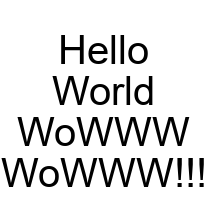

In [27]:
# from PIL import Image, ImageDraw, ImageFont
# import math

# text = "Hello\nWorld\nWoWWW\nWoWWW!!!"
# font_size = 40
# fnt = ImageFont.truetype("arial.ttf", font_size)
# image_size = (224, 224)
# biggest_word = sorted(text.split('\n'), key = lambda x: len(x))[-1]
# max_width = ImageDraw.Draw(Image.new("RGB", (100, 100), (255, 0, 0))).textlength(biggest_word, font=fnt)
# image_size = (math.ceil(max_width), 224)
# out = Image.new("RGB", image_size, (255, 255, 255))
# d = ImageDraw.Draw(out)
# d.multiline_text((image_size[0]/2, image_size[1]/2), text, font=fnt, fill=(0, 0, 0), align ="center", anchor="mm")

# out.show()

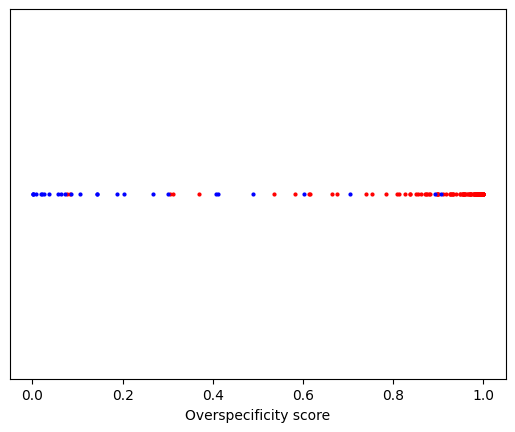

In [18]:
import matplotlib.pyplot as plt

# Example list of tuples
data = overspecificity_score_and_proto_mask

# Separate the data based on the second value
x_0 = [x for x, y, z in data if z == 0]  # First values where the second value is 0
x_1 = [x for x, y, z in data if z == 1]  # First values where the second value is 1

# Create a dummy y-axis value since this is a one-dimensional scatter plot
# y_0 = [y for x, y, z in data if z == 0]  # Dummy y values for blue points
# y_1 = [y for x, y, z in data if z == 1]  # Dummy y values for red points

# y_0 = [1]*len(x_0)
# y_1 = [1.5]*len(x_1)

y_0 = [1]*len(x_0)
y_1 = [1]*len(x_1)

# Plot the data
plt.scatter(x_1, y_1, color='red', label='Value 1', s=4)   # Plot points with second value 1 in red
plt.scatter(x_0, y_0, color='blue', label='Value 0', s=4)  # Plot points with second value 0 in blue


# Additional plot formatting
plt.xlabel('Overspecificity score')
# plt.ylabel('Num descendants')  # Hide y-axis ticks since it's a one-dimensional plot
plt.yticks([])
# plt.legend(loc='best')
# plt.title('One-dimensional Scatter Plot')
plt.show()


In [15]:
!pip show cairosvg